# Прогнозирование температуры сплава

# Общая информация
- Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава.

# Цель работы
- Построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса.

# План работы

- Загрузить данные
- Провести исследовательский анализ и предобработку данных
- Обучить разные типы моделей (деревянные модели, бустинги, нейронные сети)
- Выбрать лучшую модель
- Протестировать ее и продемонстрировать работу на тестовой выборке
- Сделать общий вывод по проделанной работе

# Описание данных

Данные хранятся в базе данных PostgreSQL. Она состоит из нескольких таблиц:
- steel.data_arc — данные об электродах;
- steel.data_bulk — данные об объёме сыпучих материалов;
- steel.data_bulk_time — данные о времени подачи сыпучих материалов;
- steel.data_gas — данные о продувке сплава газом;
- steel.data_temp — данные об измерениях температуры;
- steel.data_wire — данные об объёме проволочных материалов;
- steel.data_wire_time — данные о времени подачи проволочных материалов.

## 1. Загрузка данных.

In [ ]:
!pip install -q -r https://raw.githubusercontent.com/iashorokhov/Requirements/main/requirements.txt

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
import torch.nn as nn
import os
from tqdm import notebook
import warnings
import torch

In [ ]:
warnings.filterwarnings('ignore')

- Библиотеки импортированы, теперь подключимся к базе данных

In [ ]:
db_config = {
'user': 'praktikum_student',# имя пользователя
'pwd': 'Sdf4$2;d-d30pp',# пароль
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432,# порт подключения
'db': 'data-science-final'# название базы данных,
}

In [ ]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db']
)

In [ ]:
con = create_engine(connection_string)

In [ ]:
RANDOM_STATE = 10062024

- Подключились к базе данных.
- Сразу объявили переменную RANDOM_STATE.
- Можно переходить к работе с таблицами.

## 2. EDA и предобработка данных.

- Прежде чем переходить непосредственно к анализу и предобработке, посмотрим схему БД, с которой будем работать.

In [ ]:
query = '''
SELECT table_name
FROM information_schema.tables
WHERE table_schema = 'steel'
'''

In [ ]:
table = pd.read_sql_query(query, con=con)

In [ ]:
table

,table_name
0,data_arc
1,data_bulk
2,data_bulk_time
3,data_gas
4,data_temp
5,data_wire
6,data_wire_time


- Схема совпадает с описанной в ТЗ
- Имеем 7 таблиц внутри БД

In [ ]:
query = '''
SELECT
    table_name,
    CASE
        WHEN COUNT(*) = 0 THEN 'Empty'
        ELSE 'Has Data'
    END AS table_status
FROM
    information_schema.tables
WHERE
    table_schema = 'steel'
    AND table_type = 'BASE TABLE'
GROUP BY
    table_name
ORDER BY
    table_status
'''

In [ ]:
table = pd.read_sql_query(query, con=con)

In [ ]:
table

,table_name,table_status
0,data_arc,Has Data
1,data_bulk,Has Data
2,data_bulk_time,Has Data
3,data_gas,Has Data
4,data_temp,Has Data
5,data_wire,Has Data
6,data_wire_time,Has Data


- Судя по таблице выше, во всех таблицах внутри БД есть данные
- Передем к конкретным таблицам
- Посмотрим таблицу steel.data_arc, в которой лежит информация об электродах

In [ ]:
query = '''
SELECT*
FROM steel.data_arc
'''

In [ ]:
table = pd.read_sql_query(query, con=con)

In [ ]:
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  int64  
 1   BeginHeat      14876 non-null  object 
 2   EndHeat        14876 non-null  object 
 3   ActivePower    14876 non-null  float64
 4   ReactivePower  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


- Пропусков нет, проверим наличие полных дублей

In [ ]:
table.duplicated().value_counts()

False    14876
Name: count, dtype: int64

- Дублей тоже нет
- Посмотрим на наличие аномалий и распределение значений в столбцах

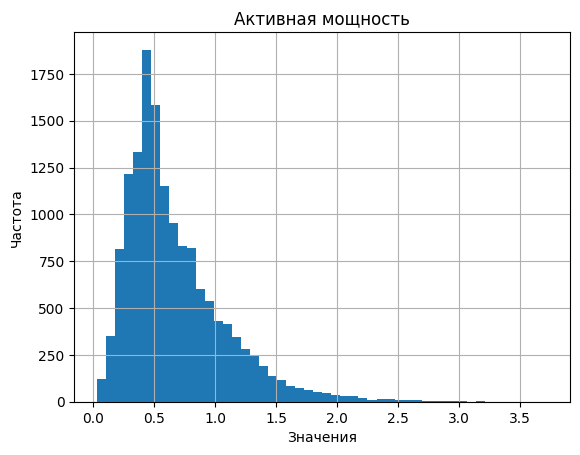

In [ ]:
plt.hist(table['ActivePower'], bins=50)

plt.title('Активная мощность')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

In [ ]:
table['ActivePower'].describe()

count    14876.000000
mean         0.670441
std          0.408159
min          0.030002
25%          0.395297
50%          0.555517
75%          0.857034
max          3.731596
Name: ActivePower, dtype: float64

- Аномальных значений нет

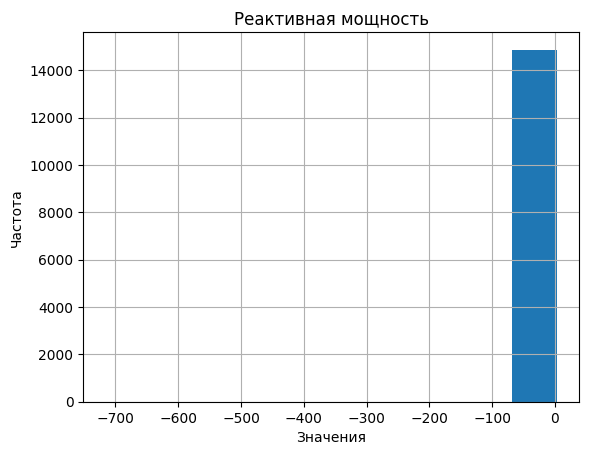

In [ ]:
plt.hist(table['ReactivePower'], bins=10)

plt.title('Реактивная мощность')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- Почти все значения реактивной мощности находятся возле 0
- Однако график показывает значения до -700, что говорит о наличии аномалий

In [ ]:
table['ReactivePower'].describe()

count    14876.000000
mean         0.452592
std          5.878702
min       -715.504924
25%          0.290991
50%          0.415962
75%          0.637371
max          2.676388
Name: ReactivePower, dtype: float64

- Аномалия, о которой шла речь выше имеет значение -715, это как раз минимальное значение в столбце, его нужно будет устранить. Вернемся к ней позднее
- Создадим столбец Duration, и посмотрим на длительность по времени между началом и концом нагрева


In [ ]:
table['BeginHeat'] = pd.to_datetime(table['BeginHeat'], format='%H:%M:%S')

In [ ]:
table['EndHeat'] = pd.to_datetime(table['EndHeat'], format='%H:%M:%S')

In [ ]:
table['Duration'] = table['EndHeat'] - table['BeginHeat']

In [ ]:
table['Duration']

0       0 days 00:03:48
1       0 days 00:03:05
2       0 days 00:02:52
3       0 days 00:06:05
4       0 days 00:02:28
              ...      
14871   0 days 00:02:37
14872   0 days 00:03:00
14873   0 days 00:03:04
14874   0 days 00:00:57
14875   0 days 00:01:21
Name: Duration, Length: 14876, dtype: timedelta64[ns]

In [ ]:
table['diff_minutes'] = table['Duration'].dt.components['minutes']

In [ ]:
table['diff_minutes']

0        3
1        3
2        2
3        6
4        2
        ..
14871    2
14872    3
14873    3
14874    0
14875    1
Name: diff_minutes, Length: 14876, dtype: int64

- Достали значения длительности в секундах. Можно посмотреть распределение

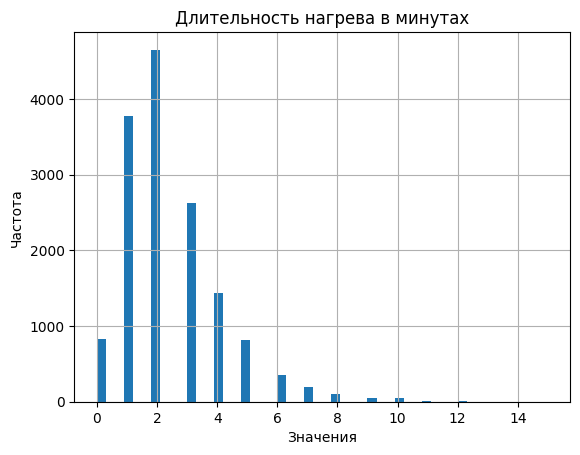

In [ ]:
plt.hist(table['diff_minutes'], bins=50)

plt.title('Длительность нагрева в минутах')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- Есть значения равные 0, что говорит об аномалии. Посчитаем сколько их и посмотрим статистические значения по столбцу

In [ ]:
table[table['diff_minutes'] == 0].value_counts()

key   BeginHeat            EndHeat              ActivePower  ReactivePower  Duration         diff_minutes
9     1900-01-01 15:56:10  1900-01-01 15:57:01  0.169568     0.115961       0 days 00:00:51  0               1
2389  1900-01-01 07:44:48  1900-01-01 07:45:45  0.242155     0.164737       0 days 00:00:57  0               1
2338  1900-01-01 06:38:35  1900-01-01 06:39:25  0.197458     0.142318       0 days 00:00:50  0               1
2339  1900-01-01 07:13:21  1900-01-01 07:14:00  0.159203     0.116906       0 days 00:00:39  0               1
2340  1900-01-01 07:36:05  1900-01-01 07:37:03  0.226095     0.156884       0 days 00:00:58  0               1
                                                                                                            ..
1161  1900-01-01 13:56:04  1900-01-01 13:56:53  0.183188     0.146438       0 days 00:00:49  0               1
1172  1900-01-01 22:28:34  1900-01-01 22:29:11  0.165344     0.106560       0 days 00:00:37  0               1
1182  

- Кажется, здесь нет аномалии, есть просто значения меньше минуты. Выведем секунды.

In [ ]:
table['diff_seconds'] = table['Duration'].dt.components['seconds']

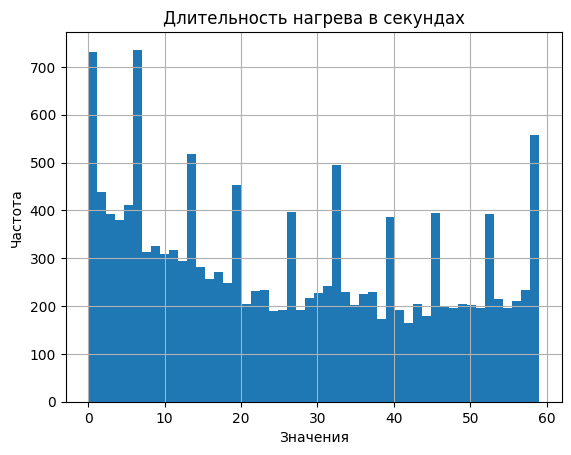

In [ ]:
plt.hist(table['diff_seconds'], bins=50)

plt.title('Длительность нагрева в секундах')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- Несмотря на наличие 0 аномалии нет, т.к. эти нуля говорят о 0 секунд, но минут больше 0
- Для наглядности выведем на экран значения с 0

In [ ]:
table[table['diff_seconds'] == 0].value_counts()

key   BeginHeat            EndHeat              ActivePower  ReactivePower  Duration         diff_minutes  diff_seconds
11    1900-01-01 17:03:01  1900-01-01 17:05:01  0.412197     0.326343       0 days 00:02:00  2             0               1
2354  1900-01-01 19:03:06  1900-01-01 19:05:06  0.411980     0.366320       0 days 00:02:00  2             0               1
2334  1900-01-01 03:07:23  1900-01-01 03:11:23  0.811358     0.587072       0 days 00:04:00  4             0               1
2326  1900-01-01 21:56:06  1900-01-01 21:58:06  0.538606     0.353802       0 days 00:02:00  2             0               1
2323  1900-01-01 18:49:31  1900-01-01 18:52:31  0.624453     0.472845       0 days 00:03:00  3             0               1
                                                                                                                          ..
1073  1900-01-01 16:21:52  1900-01-01 16:23:52  0.539762     0.356849       0 days 00:02:00  2             0               1
1069 

- По итогу у нас есть три дополнительных признака длительность нагрева, количество минут нагрева, количество секунд нагрева.
- Заменим аномалии в реактивной мощности на среднее

In [ ]:
table.loc[table['ReactivePower'] < 0] = table['ReactivePower'].mean()

In [ ]:
table['ReactivePower'].describe()

count    14876.000000
mean         0.500720
std          0.310870
min          0.020806
25%          0.291008
50%          0.416083
75%          0.637371
max          2.676388
Name: ReactivePower, dtype: float64

- Аномалия устранена. Сохраним таблицу в отдельную переменную и перейдем к следующей таблице.

In [ ]:
data_arc = table

In [ ]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  float64
 1   BeginHeat      14876 non-null  object 
 2   EndHeat        14876 non-null  object 
 3   ActivePower    14876 non-null  float64
 4   ReactivePower  14876 non-null  float64
 5   Duration       14876 non-null  object 
 6   diff_minutes   14876 non-null  float64
 7   diff_seconds   14876 non-null  float64
dtypes: float64(5), object(3)
memory usage: 929.9+ KB


- Лишние признаки уберем позднее.
- Следующая таблица steel.data_bulk

In [ ]:
query = '''
SELECT*
FROM steel.data_bulk
'''

In [ ]:
table = pd.read_sql_query(query, con=con)
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


- Очень много пропусков, которые говорят о том, что материал не добавляли в партию
- Из этого следуюет, что все пропуски нужно заменить на 0, но для начала посмотрим на признаки

In [ ]:
table.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


- Сразу бросается в глаза Bulk 8, который использовался всего 1 раз из 3129
- Аналогичная ситуация с Bulk 9 (19 раз), Bulk 7 (25 раз), Bulk 2 (22 раза) и Bulk 13 (18 раз)
- Чаще всего использовался Bukl 14 - 2806 раз, при этом в самых разных объемах
- По среднему объему лидирует Bulk 7 - mean = 305

Итого:
- Bulk 8 - лучшим решением кажется удалить столбец
- Пропуски заменим на 0

In [ ]:
table = table.drop('Bulk 8', axis=1)
table = table.fillna(0)

In [ ]:
table.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
5,6,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,201.0,154.0
6,7,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,152.0,154.0
7,8,0.0,0.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,410.0,0.0,252.0,153.0
8,9,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0,0.0,99.0,203.0
9,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,102.0,204.0


- Сохраним таблицу в отдельную переменную

In [ ]:
data_bulk = table

- Можно переходить к следующей таблице

In [ ]:
query = '''
SELECT *
FROM steel.data_bulk_time
'''

In [ ]:
table = pd.read_sql_query(query, con=con)
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


- Т.к. здесь представлена информация по тем же материалам, что и в предыдущей таблице, сразу можно отметить пропуски, которые заменим на 0 (материал не использовался)

In [ ]:
table.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,11:21:30,None,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,None,None,None,12:31:06,None,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40
3,4,None,None,None,12:48:43,None,None,None,None,None,None,None,12:41:24,None,12:41:24,12:41:24
4,5,None,None,None,13:18:50,None,None,None,None,None,None,None,13:12:56,None,13:12:56,13:12:56
5,6,None,None,None,13:59:24,None,None,None,None,None,None,None,13:53:27,None,13:53:27,13:53:27
6,7,None,None,None,14:29:14,None,None,None,None,None,None,None,14:22:19,None,14:22:19,14:22:19
7,8,None,None,None,15:04:05,None,None,None,None,None,None,None,14:55:46,None,14:55:46,14:55:46
8,9,None,None,None,15:47:34,None,None,None,None,None,None,None,15:41:00,None,15:41:00,15:41:00
9,10,None,None,None,None,None,None,None,None,None,None,None,16:18:52,None,16:18:52,16:18:52


In [ ]:
table['Bulk 1'] = pd.to_datetime(table['Bulk 1'], format='%H:%M:%S')

In [ ]:
table['Bulk 1'].describe()

count                              252
mean     1900-01-01 12:43:51.746031872
min                1900-01-01 00:00:13
25%                1900-01-01 08:05:01
50%                1900-01-01 13:15:09
75%      1900-01-01 17:18:12.750000128
max                1900-01-01 23:54:24
Name: Bulk 1, dtype: object

- Максимальное значение аж 23:54:24, т.е. подача материала заняла сутки, что явно выбивается и вяглядит как аномалия


In [ ]:
table['Bulk 2'] = pd.to_datetime(table['Bulk 2'], format='%H:%M:%S')

In [ ]:
table['Bulk 2'].describe()

count                               22
mean     1900-01-01 12:59:17.272727296
min                1900-01-01 08:36:19
25%                1900-01-01 10:14:05
50%                1900-01-01 11:52:03
75%         1900-01-01 15:43:36.500000
max                1900-01-01 18:01:50
Name: Bulk 2, dtype: object

- Здесь тоже максимальное значение высокое, хотя и меньше суток

In [ ]:
table['Bulk 3'] = pd.to_datetime(table['Bulk 3'], format='%H:%M:%S')

In [ ]:
table['Bulk 3'].describe()

count                             1298
mean     1900-01-01 12:12:29.822804224
min                1900-01-01 00:00:01
25%      1900-01-01 06:26:22.750000128
50%                1900-01-01 11:59:08
75%         1900-01-01 18:15:34.500000
max                1900-01-01 23:57:32
Name: Bulk 3, dtype: object

- Снова максимальное значение 23:57:32
- Данные все больше выглядят неадекватными

In [ ]:
table['Bulk 4'] = pd.to_datetime(table['Bulk 4'], format='%H:%M:%S')
table['Bulk 4'].describe()

count                             1014
mean     1900-01-01 11:22:40.462524160
min                1900-01-01 00:00:38
25%                1900-01-01 05:26:34
50%                1900-01-01 10:43:33
75%      1900-01-01 17:04:10.750000128
max                1900-01-01 23:59:30
Name: Bulk 4, dtype: object

- Аналогично предыдущему столбцу
- Посмотрим сразу все, затем сделаем выводы

In [ ]:
table['Bulk 5'] = pd.to_datetime(table['Bulk 5'], format='%H:%M:%S')
table['Bulk 5'].describe()

count                               77
mean     1900-01-01 11:27:22.389610496
min                1900-01-01 00:01:33
25%                1900-01-01 04:27:52
50%                1900-01-01 11:08:58
75%                1900-01-01 18:01:50
max                1900-01-01 23:42:34
Name: Bulk 5, dtype: object

In [ ]:
table['Bulk 6'] = pd.to_datetime(table['Bulk 6'], format='%H:%M:%S')
table['Bulk 6'].describe()

count                              576
mean     1900-01-01 12:12:30.003472128
min                1900-01-01 00:01:25
25%                1900-01-01 06:01:32
50%                1900-01-01 12:10:45
75%                1900-01-01 18:37:40
max                1900-01-01 23:56:15
Name: Bulk 6, dtype: object

In [ ]:
table['Bulk 7'] = pd.to_datetime(table['Bulk 7'], format='%H:%M:%S')
table['Bulk 7'].describe()

count                            25
mean     1900-01-01 11:05:05.040000
min             1900-01-01 00:42:38
25%             1900-01-01 08:46:28
50%             1900-01-01 11:10:20
75%             1900-01-01 14:05:53
max             1900-01-01 18:01:50
Name: Bulk 7, dtype: object

In [ ]:
table['Bulk 8'] = pd.to_datetime(table['Bulk 8'], format='%H:%M:%S')
table['Bulk 8'].describe()

count                      1
mean     1900-01-01 17:46:11
min      1900-01-01 17:46:11
25%      1900-01-01 17:46:11
50%      1900-01-01 17:46:11
75%      1900-01-01 17:46:11
max      1900-01-01 17:46:11
Name: Bulk 8, dtype: object

- Как мы поняли по предыдущей таблице, Bulk 8 имеет всего 1 наблюдение, поэтому здесь повторяются значения

In [ ]:
table['Bulk 9'] = pd.to_datetime(table['Bulk 9'], format='%H:%M:%S')
table['Bulk 9'].describe()

count                               19
mean     1900-01-01 08:28:27.368420864
min                1900-01-01 00:04:56
25%         1900-01-01 02:37:23.500000
50%                1900-01-01 05:15:06
75%         1900-01-01 14:13:48.500000
max                1900-01-01 18:58:01
Name: Bulk 9, dtype: object

In [ ]:
table['Bulk 10'] = pd.to_datetime(table['Bulk 10'], format='%H:%M:%S')
table['Bulk 10'].describe()

count                              176
mean     1900-01-01 11:19:31.465909248
min                1900-01-01 00:01:01
25%         1900-01-01 06:23:19.500000
50%                1900-01-01 10:51:11
75%         1900-01-01 16:29:57.500000
max                1900-01-01 23:32:50
Name: Bulk 10, dtype: object

In [ ]:
table['Bulk 11'] = pd.to_datetime(table['Bulk 11'], format='%H:%M:%S')
table['Bulk 11'].describe()

count                              177
mean     1900-01-01 12:28:39.192090368
min                1900-01-01 00:28:29
25%                1900-01-01 06:34:30
50%                1900-01-01 11:57:24
75%                1900-01-01 18:07:49
max                1900-01-01 23:56:15
Name: Bulk 11, dtype: object

- Думаю достаточно. Более половины столбцов имеют неадекватные значения, при которых загрузка выглядит слишком долгой
- Есть предположение, что здесь все же указано время начала или время конца загрузки
- Помимо этого, большая часть таблицы это пропуски
- Кажется, что эту таблицу нет смысла использовать для обучения модели, т.к. признаки неадекватны
- Перейдем к следующей таблице

In [ ]:
query = '''
SELECT *
FROM steel.data_gas
'''

In [ ]:
table = pd.read_sql_query(query, con=con)
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


- Пропусков нет, проврерим дубли и затем посмотрим на распределение объема газа

In [ ]:
table.duplicated().value_counts()

False    3239
Name: count, dtype: int64

- Дублей тоже нет
- Построим основные метрики и построим график распределения

In [ ]:
table['gas'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: gas, dtype: float64

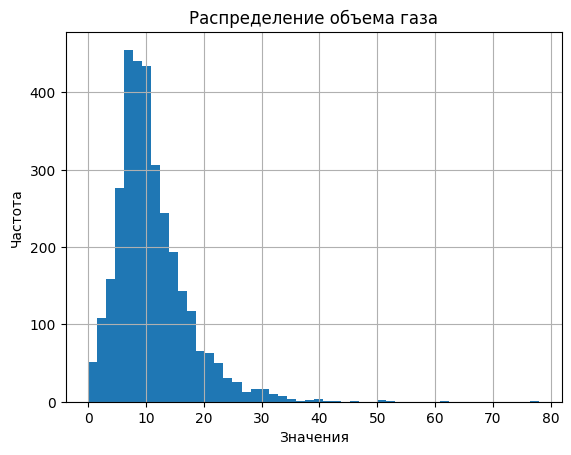

In [ ]:
plt.hist(table['gas'], bins=50)

plt.title('Распределение объема газа')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- Минимальное значение 0.008
- Максимальное 78
- Среднее 11
- В целом ничего подозрительного, кроме минимального значения, однако все зависит от меры измерения объема и, в целом, такая цифра имеет место быть
- Сохраним данные в отдельную переменную

In [ ]:
data_gas = table

- Перейдем к следующей таблице

In [ ]:
query = '''
SELECT *
FROM steel.data_temp
'''

In [ ]:
table = pd.read_sql_query(query, con=con)
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          15907 non-null  int64  
 1   MesaureTime  15907 non-null  object 
 2   Temperature  13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [ ]:
table.head()

,key,MesaureTime,Temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0
3,1,11:30:01,1601.0
4,1,11:30:39,1613.0


- Для начала отсортируем таблицу так, чтобы оставить только те значения, в которых key встречается минимум 2 раза, т.е. имеет два значения температуры

In [ ]:
table = table.sort_values('key')
key_counts = table['key'].value_counts()
valid_keys = key_counts[key_counts >= 2].index
table = table[table['key'].isin(valid_keys)]

In [ ]:
table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15905 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          15905 non-null  int64  
 1   MesaureTime  15905 non-null  object 
 2   Temperature  13004 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 497.0+ KB


In [ ]:
table['key'].value_counts()

key
1214    16
46      16
44      16
1513    16
2108    15
        ..
669      2
722      2
2312     2
776      2
744      2
Name: count, Length: 3214, dtype: int64

- Готово, теперь нужно отсортировать таблицу по датам и оставить только первый и последний замер температуры

In [ ]:
table['MesaureTime'] = pd.to_datetime(table['MesaureTime'], format='%H:%M:%S')

In [ ]:
table = table.sort_values('MesaureTime') # Соритируем таблицу по времени

In [ ]:
table = table.groupby("key")[["MesaureTime", "Temperature"]].agg({"MesaureTime": ["first", "last"], "Temperature": ["first", "last"]}) # группируем по key и выбираем первое и последнее значение группы

In [ ]:
table.columns = ["MesaureTime_first", "MesaureTime_last", "Temperature_first", "Temperature_last"]
table = table.reset_index()
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                3214 non-null   int64         
 1   MesaureTime_first  3214 non-null   datetime64[ns]
 2   MesaureTime_last   3214 non-null   datetime64[ns]
 3   Temperature_first  3214 non-null   float64       
 4   Temperature_last   3214 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 125.7 KB


- Получили отсортированную таблицу, можно перейти к анализу
- Посмотрим основные метрики и построим графики распределений

In [ ]:
table['Temperature_first'].describe()

count    3214.000000
mean     1588.544804
std        29.068027
min      1191.000000
25%      1572.000000
50%      1588.000000
75%      1605.000000
max      1684.000000
Name: Temperature_first, dtype: float64

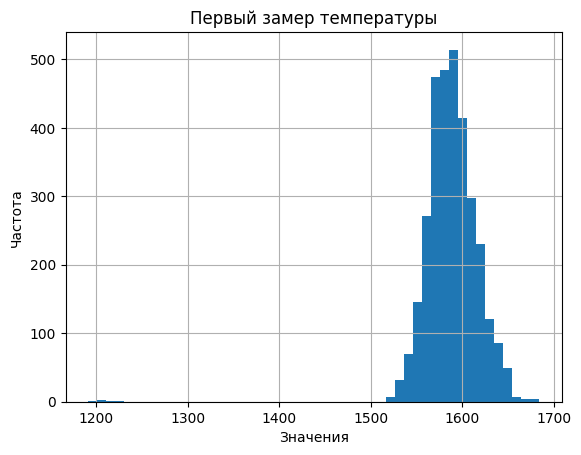

In [ ]:
plt.hist(table['Temperature_first'], bins=50)

plt.title('Первый замер температуры')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- Первичные замеры имеют аномалии, все что ниже 1500. Этот порог установил заказчик
- Среднее значение температуры 1588
- Максимальное 1684
- Чтобы принять решение по аномалиям, посчитаем их количество

In [ ]:
table[table['Temperature_first'] < 1500].value_counts()

key   MesaureTime_first    MesaureTime_last     Temperature_first  Temperature_last
867   1900-01-01 14:21:00  1900-01-01 14:57:17  1191.0             1599.0              1
1214  1900-01-01 05:32:00  1900-01-01 06:14:45  1208.0             1591.0              1
1619  1900-01-01 11:03:54  1900-01-01 11:21:54  1218.0             1590.0              1
2052  1900-01-01 14:51:40  1900-01-01 15:24:06  1227.0             1592.0              1
2561  1900-01-01 07:34:15  1900-01-01 07:56:57  1204.0             1204.0              1
Name: count, dtype: int64

- 5 значений, можно заменить на среднее

In [ ]:
table.loc[table['Temperature_first'] < 1500] = table['Temperature_first'].mean()

In [ ]:
table['Temperature_first'].describe()

count    3214.000000
mean     1589.134326
std        24.917911
min      1519.000000
25%      1572.000000
50%      1588.000000
75%      1605.000000
max      1684.000000
Name: Temperature_first, dtype: float64

- Перейдем к следующему столбцу

In [ ]:
table['Temperature_last'].describe()

count    3214.000000
mean     1593.892571
std        18.769605
min      1529.000000
25%      1585.000000
50%      1592.000000
75%      1600.000000
max      1700.000000
Name: Temperature_last, dtype: float64

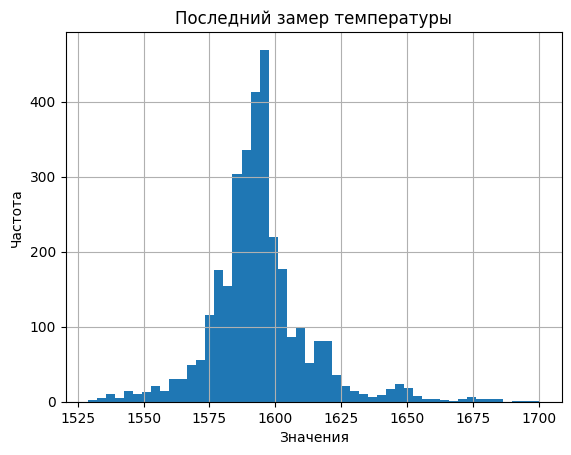

In [ ]:
plt.hist(table['Temperature_last'], bins=50)

plt.title('Последний замер температуры')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- Последний замер не особо отличается от первого
- Минимальное значение температуры 1529
- Максимальное значение 1700
- Среднее 1593, что почти не отличается от предыдущего столбца, там среднее было 1589
- Аномалий не обнаружено, все значения выше 1500

Можно использовать первичный замер температуры в качестве признака для обучения модели. Целевой признак мы также получили. Сохраним эту таблицу в переменную и перейдем к следующей

In [ ]:
data_temp = table

In [ ]:
query = '''
SELECT *
FROM steel.data_wire
'''

In [ ]:
table = pd.read_sql_query(query, con=con)
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


- Куча пропусков говорит, что материал не добавляли в партию
- Заменим их на 0, но сначала посмотрим основные метрики

In [ ]:
table.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


- Сразу бросается в глаза Wire 5, где всего 1 значение и Wire 1, где значения почти полностью соответствуют количеству партий
- Из этого следует, что чаще всего используется Wire 1, затем Wire 2, а остальные материалы используются редко
- Пока оставим все как есть и заполним пропуски, позже решим нужны ли эти данные в качестве признаков

In [ ]:
table = table.fillna(0)
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
 3   Wire 3  3081 non-null   float64
 4   Wire 4  3081 non-null   float64
 5   Wire 5  3081 non-null   float64
 6   Wire 6  3081 non-null   float64
 7   Wire 7  3081 non-null   float64
 8   Wire 8  3081 non-null   float64
 9   Wire 9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [ ]:
data_wire = table

- Пропуски заполнены, переходим к последней таблице в нашей БД

In [ ]:
query = '''
SELECT *
FROM steel.data_wire_time
'''

In [ ]:
table = pd.read_sql_query(query, con=con)
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


- здесь у нас информация по времени загрузки материала
- также много пропусков
- проверим данные на адекваиность, есть сомнения по поводу практичности использования этой информации для обучения модели

In [ ]:
table['Wire 1'] = pd.to_datetime(table['Wire 1'], format='%H:%M:%S')
table['Wire 1'].describe()

count                             3055
mean     1900-01-01 11:52:15.153846528
min                1900-01-01 00:00:37
25%         1900-01-01 05:50:10.500000
50%                1900-01-01 11:41:37
75%         1900-01-01 17:55:57.500000
max                1900-01-01 23:59:55
Name: Wire 1, dtype: object

- И снова максимально значение равно целым суткам, как и в случае с драгими материалами
- Посмотрим еще несколько столбцов

In [ ]:
table['Wire 2'] = pd.to_datetime(table['Wire 2'], format='%H:%M:%S')
table['Wire 2'].describe()

count                             1079
mean     1900-01-01 12:00:30.911955456
min                1900-01-01 00:01:56
25%         1900-01-01 05:47:23.500000
50%                1900-01-01 12:17:11
75%         1900-01-01 18:04:27.500000
max                1900-01-01 23:58:54
Name: Wire 2, dtype: object

In [ ]:
table['Wire 3'] = pd.to_datetime(table['Wire 3'], format='%H:%M:%S')
table['Wire 3'].describe()

count                               63
mean     1900-01-01 13:45:31.634920448
min                1900-01-01 01:29:02
25%                1900-01-01 09:10:02
50%                1900-01-01 14:40:37
75%                1900-01-01 18:09:56
max                1900-01-01 23:27:46
Name: Wire 3, dtype: object

In [ ]:
table['Wire 4'] = pd.to_datetime(table['Wire 4'], format='%H:%M:%S')
table['Wire 4'].describe()

count                               14
mean     1900-01-01 11:49:45.428571392
min                1900-01-01 07:15:28
25%      1900-01-01 09:19:03.249999872
50%                1900-01-01 11:19:01
75%      1900-01-01 14:01:09.750000128
max                1900-01-01 18:09:32
Name: Wire 4, dtype: object

In [ ]:
table['Wire 5'] = pd.to_datetime(table['Wire 5'], format='%H:%M:%S')
table['Wire 5'].describe()

count                      1
mean     1900-01-01 16:01:07
min      1900-01-01 16:01:07
25%      1900-01-01 16:01:07
50%      1900-01-01 16:01:07
75%      1900-01-01 16:01:07
max      1900-01-01 16:01:07
Name: Wire 5, dtype: object

- В Wire 5 одно значение в принципе, т.е. материал использовали только единожды

In [ ]:
table['Wire 6'] = pd.to_datetime(table['Wire 6'], format='%H:%M:%S')
table['Wire 6'].describe()

count                               73
mean     1900-01-01 13:27:39.643835392
min                1900-01-01 00:04:33
25%                1900-01-01 09:20:22
50%                1900-01-01 14:12:27
75%                1900-01-01 18:10:03
max                1900-01-01 23:47:40
Name: Wire 6, dtype: object

In [ ]:
table['Wire 6'] = pd.to_datetime(table['Wire 6'], format='%H:%M:%S')
table['Wire 6'].describe()

count                               73
mean     1900-01-01 13:27:39.643835392
min                1900-01-01 00:04:33
25%                1900-01-01 09:20:22
50%                1900-01-01 14:12:27
75%                1900-01-01 18:10:03
max                1900-01-01 23:47:40
Name: Wire 6, dtype: object

In [ ]:
table['Wire 7'] = pd.to_datetime(table['Wire 7'], format='%H:%M:%S')
table['Wire 7'].describe()

count                               11
mean     1900-01-01 14:14:46.727272704
min                1900-01-01 10:01:56
25%         1900-01-01 11:46:13.500000
50%                1900-01-01 12:42:00
75%                1900-01-01 17:36:39
max                1900-01-01 19:46:16
Name: Wire 7, dtype: object

- Думаю достаточно, чтобы сделать вывод о том, что данные не адекватны
- Как и в таблице с материалом Bulk, есть предположение, что здесь все таки омечено время начала загрузки материала, что по факту ничего нам не даст
- Не вижу смысла использовать эту таблицу в качетсве входных признаков

## Промежуточный вывод
- Почти все значения реактивной мощности находятся возле 0
- Однако график показывает значения до -700, что говорит о наличии аномалий
- Заменили аномалии в реактивной мощности на среднее значение
- Очень много пропусков в столбцах с материалами, которые говорят о том, что материал не добавляли в партию
- Все пропуски были заменены на 0
- Материал Bulk 8 использовался всего 1 раз из 3129
- Аналогичная ситуация с Bulk 9 (19 раз), Bulk 7 (25 раз), Bulk 2 (22 раза) и Bulk 13 (18 раз)
- Чаще всего использовался Bukl 14 - 2806 раз, при этом в самых разных объемах
- По среднему объему лидирует Bulk 7 - mean = 305
- Таблицы со временем добавления материала оказались неинформативными
- Более половины столбцов имеют неадекватные значения, при которых загрузка выглядит слишком долгой
- В таблице gas аномалий не обнаружено
- Минимальное значение 0.008
- Максимальное 78
- Среднее 11
- В стобце с температурой были обнаружены аномалии (значения ниже 1500)
- Аномалии заменены на среднее
- Среднее значение температуры 1593
- Максимальное 1700
- Минимальное значение температуры 1529
- В таблице с материалом Wire так же много пропусков, которые заполнились на 0
- В таблице с временем загрузки материала Wire тоже много пропусков, плюс данные не адекватны

Можно переходить к объединению таблиц по ключу.

Отберем только партии, где есть первое и последнее значение температуры.

Агрегируем суммарную мощность

Проверим, что все таблицы содержат нужный нам столбец и он везде одинакового формата

In [ ]:
data_temp.shape

(3214, 5)

In [ ]:
data_temp = data_temp[(data_temp['Temperature_first'] != data_temp['Temperature_last'])]

In [ ]:
data_temp.shape

(2428, 5)

In [ ]:
data_arc['AllPower'] = data_arc['ActivePower'] + data_arc['ReactivePower']

In [ ]:
data_arc.head(5)

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,Duration,diff_minutes,diff_seconds,AllPower
0,1.0,1900-01-01 11:02:14,1900-01-01 11:06:02,0.976059,0.687084,0 days 00:03:48,3.0,48.0,1.663142
1,1.0,1900-01-01 11:07:28,1900-01-01 11:10:33,0.805607,0.520285,0 days 00:03:05,3.0,5.0,1.325892
2,1.0,1900-01-01 11:11:44,1900-01-01 11:14:36,0.744363,0.498805,0 days 00:02:52,2.0,52.0,1.243169
3,1.0,1900-01-01 11:18:14,1900-01-01 11:24:19,1.659363,1.062669,0 days 00:06:05,6.0,5.0,2.722032
4,1.0,1900-01-01 11:26:09,1900-01-01 11:28:37,0.692755,0.414397,0 days 00:02:28,2.0,28.0,1.107152


In [ ]:
data_arc['TotalPower'] = data_arc.groupby('key')['AllPower'].transform('sum')

In [ ]:
data_arc.head()

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,Duration,diff_minutes,diff_seconds,AllPower,TotalPower
0,1.0,1900-01-01 11:02:14,1900-01-01 11:06:02,0.976059,0.687084,0 days 00:03:48,3.0,48.0,1.663142,8.061388
1,1.0,1900-01-01 11:07:28,1900-01-01 11:10:33,0.805607,0.520285,0 days 00:03:05,3.0,5.0,1.325892,8.061388
2,1.0,1900-01-01 11:11:44,1900-01-01 11:14:36,0.744363,0.498805,0 days 00:02:52,2.0,52.0,1.243169,8.061388
3,1.0,1900-01-01 11:18:14,1900-01-01 11:24:19,1.659363,1.062669,0 days 00:06:05,6.0,5.0,2.722032,8.061388
4,1.0,1900-01-01 11:26:09,1900-01-01 11:28:37,0.692755,0.414397,0 days 00:02:28,2.0,28.0,1.107152,8.061388


In [ ]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   3129 non-null   float64
 2   Bulk 2   3129 non-null   float64
 3   Bulk 3   3129 non-null   float64
 4   Bulk 4   3129 non-null   float64
 5   Bulk 5   3129 non-null   float64
 6   Bulk 6   3129 non-null   float64
 7   Bulk 7   3129 non-null   float64
 8   Bulk 9   3129 non-null   float64
 9   Bulk 10  3129 non-null   float64
 10  Bulk 11  3129 non-null   float64
 11  Bulk 12  3129 non-null   float64
 12  Bulk 13  3129 non-null   float64
 13  Bulk 14  3129 non-null   float64
 14  Bulk 15  3129 non-null   float64
dtypes: float64(14), int64(1)
memory usage: 366.8 KB


In [ ]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [ ]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2428 entries, 0 to 2474
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2428 non-null   float64
 1   MesaureTime_first  2428 non-null   object 
 2   MesaureTime_last   2428 non-null   object 
 3   Temperature_first  2428 non-null   float64
 4   Temperature_last   2428 non-null   float64
dtypes: float64(3), object(2)
memory usage: 113.8+ KB


In [ ]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
 3   Wire 3  3081 non-null   float64
 4   Wire 4  3081 non-null   float64
 5   Wire 5  3081 non-null   float64
 6   Wire 6  3081 non-null   float64
 7   Wire 7  3081 non-null   float64
 8   Wire 8  3081 non-null   float64
 9   Wire 9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


- Столбцы key есть везде, а вот форматы разные
- Заменим формат столбцов key во всех таблицах на int, так как номер партии целое число

In [ ]:
data_arc['key'] = data_arc['key'].astype(int)

In [ ]:
data_temp['key'] = data_temp['key'].astype(int)

- Теперь можно объединять таблицы

In [ ]:
df = pd.merge(data_arc, data_bulk, on='key', how='inner')

In [ ]:
df = pd.merge(df, data_gas, on='key', how='inner')

In [ ]:
df = pd.merge(df, data_temp, on='key', how='inner')

In [ ]:
df = pd.merge(df, data_wire, on='key', how='inner')

In [ ]:
df = df.drop_duplicates('key')

In [ ]:
df.shape

(2288, 38)

In [ ]:
display(df)

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,Duration,diff_minutes,diff_seconds,AllPower,TotalPower,...,Temperature_last,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,1900-01-01 11:02:14,1900-01-01 11:06:02,0.976059,0.687084,0 days 00:03:48,3.0,48.0,1.663142,8.061388,...,1613.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2,1900-01-01 11:34:14,1900-01-01 11:36:31,0.438063,0.283043,0 days 00:02:17,2.0,17.0,0.721107,5.050710,...,1602.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,3,1900-01-01 12:06:54,1900-01-01 12:11:34,1.062053,0.671494,0 days 00:04:40,4.0,40.0,1.733547,4.124958,...,1599.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,4,1900-01-01 12:39:37,1900-01-01 12:43:04,0.875313,0.614404,0 days 00:03:27,3.0,27.0,1.489718,5.269548,...,1625.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,5,1900-01-01 13:11:13,1900-01-01 13:15:24,0.950026,0.690523,0 days 00:04:11,4.0,11.0,1.640548,5.599815,...,1602.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10731,2495,1900-01-01 00:31:05,1900-01-01 00:34:32,0.875021,0.705281,0 days 00:03:27,3.0,27.0,1.580302,5.571467,...,1591.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10735,2496,1900-01-01 01:00:06,1900-01-01 01:02:03,0.393625,0.287355,0 days 00:01:57,1.0,57.0,0.680981,7.013249,...,1591.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10741,2497,1900-01-01 01:38:01,1900-01-01 01:40:37,0.580983,0.504512,0 days 00:02:36,2.0,36.0,1.085495,4.063648,...,1589.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10744,2498,1900-01-01 01:57:46,1900-01-01 02:02:02,1.162895,0.832519,0 days 00:04:16,4.0,16.0,1.995413,5.764154,...,1594.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- Получили общую таблицу
- Проведем анализ всех признаков
- Столбцы с датами и временем нагрева (BeginHeat и EndHeat) использовать не будем, т.к. уже получен столбце с продолжительностью нагрева, а сами по себе значения старта и конца нагрева ничего не дадут


In [ ]:
df.tail()

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,Duration,diff_minutes,diff_seconds,AllPower,TotalPower,...,Temperature_last,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
10731,2495,1900-01-01 00:31:05,1900-01-01 00:34:32,0.875021,0.705281,0 days 00:03:27,3.0,27.0,1.580302,5.571467,...,1591.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10735,2496,1900-01-01 01:00:06,1900-01-01 01:02:03,0.393625,0.287355,0 days 00:01:57,1.0,57.0,0.680981,7.013249,...,1591.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10741,2497,1900-01-01 01:38:01,1900-01-01 01:40:37,0.580983,0.504512,0 days 00:02:36,2.0,36.0,1.085495,4.063648,...,1589.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10744,2498,1900-01-01 01:57:46,1900-01-01 02:02:02,1.162895,0.832519,0 days 00:04:16,4.0,16.0,1.995413,5.764154,...,1594.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10749,2499,1900-01-01 02:32:56,1900-01-01 02:38:08,1.425867,1.043338,0 days 00:05:12,5.0,12.0,2.469205,6.876296,...,1603.0,110.160958,50.00528,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df = df.drop(['BeginHeat', 'EndHeat'], axis=1)

- Построим графики распределения для признаков

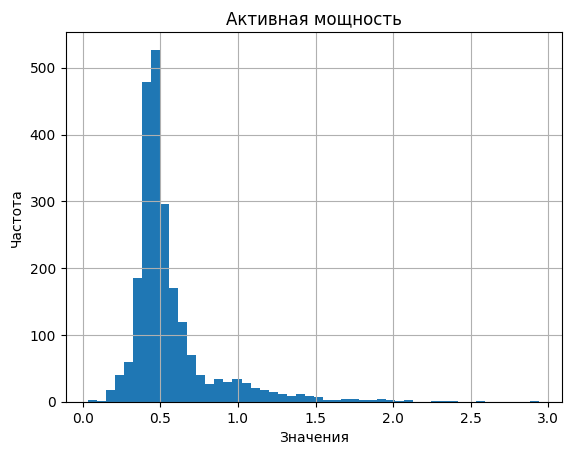

In [ ]:
plt.hist(df['ActivePower'], bins=50)

plt.title('Активная мощность')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- В основном активная мощность составляет от 0.3 - 0.7

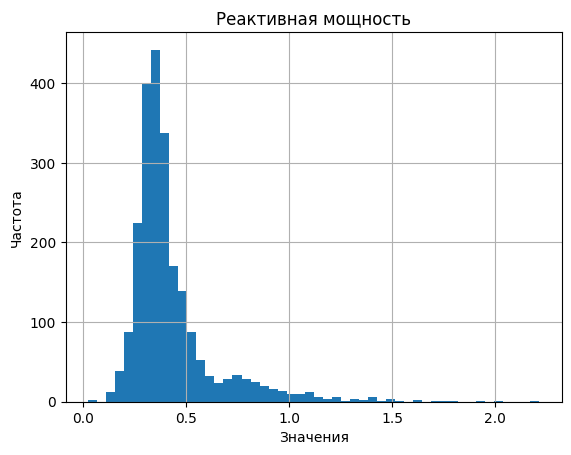

In [ ]:
plt.hist(df['ReactivePower'], bins=50)

plt.title('Реактивная мощность')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- Реактивная мощность в основном в диапазоне от 0.25 до 0.6

- Прежде чем переходить к столбцу с длительностью, переведем значения в секунды

In [ ]:
df['Duration'] = df['Duration'].apply(lambda x: pd.Timedelta(x).total_seconds())

In [ ]:
df.head()

,key,ActivePower,ReactivePower,Duration,diff_minutes,diff_seconds,AllPower,TotalPower,Bulk 1,Bulk 2,...,Temperature_last,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,0.976059,0.687084,228.0,3.0,48.0,1.663142,8.061388,0.0,0.0,...,1613.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2,0.438063,0.283043,137.0,2.0,17.0,0.721107,5.050710,0.0,0.0,...,1602.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,3,1.062053,0.671494,280.0,4.0,40.0,1.733547,4.124958,0.0,0.0,...,1599.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,4,0.875313,0.614404,207.0,3.0,27.0,1.489718,5.269548,0.0,0.0,...,1625.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,5,0.950026,0.690523,251.0,4.0,11.0,1.640548,5.599815,0.0,0.0,...,1602.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


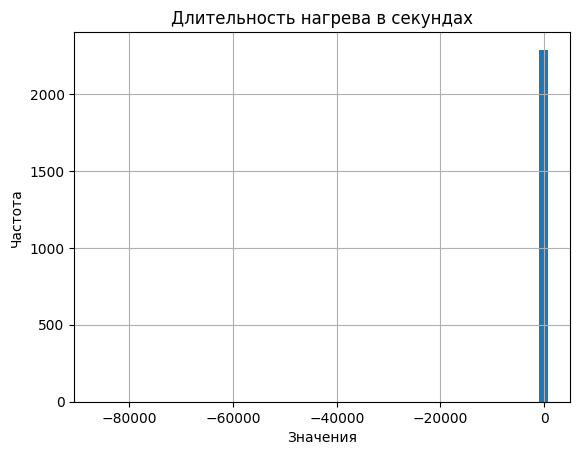

In [ ]:
plt.hist(df['Duration'], bins=50)

plt.title('Длительность нагрева в секундах')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- Судя по всему остались аномалии, раз есть отрицательные значения
- Устраним их

In [ ]:
df = df[df['Duration'] >= 0]

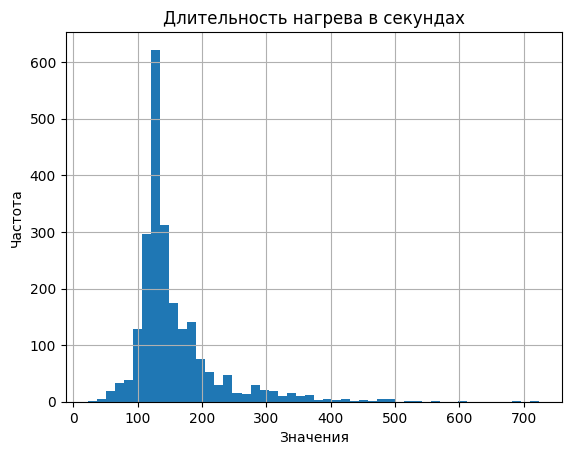

In [ ]:
plt.hist(df['Duration'], bins=50)

plt.title('Длительность нагрева в секундах')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- В среднем длительность нагрева в диапазоне от 100 - 150 секунд

- Столбцы diff_seconds и diff_minutes по сути повторяют предыдущую информацию, думаю от этих признаков можно избавиться

In [ ]:
df = df.drop(['diff_minutes', 'diff_seconds'], axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2287 entries, 0 to 10749
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2287 non-null   int64  
 1   ActivePower        2287 non-null   float64
 2   ReactivePower      2287 non-null   float64
 3   Duration           2287 non-null   float64
 4   AllPower           2287 non-null   float64
 5   TotalPower         2287 non-null   float64
 6   Bulk 1             2287 non-null   float64
 7   Bulk 2             2287 non-null   float64
 8   Bulk 3             2287 non-null   float64
 9   Bulk 4             2287 non-null   float64
 10  Bulk 5             2287 non-null   float64
 11  Bulk 6             2287 non-null   float64
 12  Bulk 7             2287 non-null   float64
 13  Bulk 9             2287 non-null   float64
 14  Bulk 10            2287 non-null   float64
 15  Bulk 11            2287 non-null   float64
 16  Bulk 12            2287 non-

- Дальше посмотрим на объемы использования материала Bulk

In [ ]:
df['Bulk 1'].value_counts()

Bulk 1
0.0      2090
27.0       75
46.0       26
48.0       14
31.0       14
44.0       11
54.0        9
29.0        6
62.0        3
34.0        3
52.0        3
73.0        3
37.0        2
39.0        2
43.0        2
92.0        2
67.0        1
10.0        1
21.0        1
19.0        1
63.0        1
30.0        1
38.0        1
41.0        1
58.0        1
83.0        1
50.0        1
33.0        1
78.0        1
60.0        1
65.0        1
90.0        1
75.0        1
69.0        1
51.0        1
94.0        1
185.0       1
47.0        1
Name: count, dtype: int64

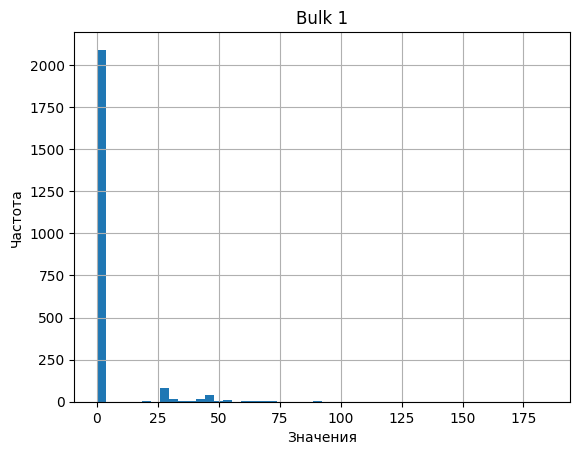

In [ ]:
plt.hist(df['Bulk 1'], bins=50)

plt.title('Bulk 1')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- Bulk 1 использовался редко, менее 300 раз
- Самое большое значение 185

In [ ]:
df['Bulk 2'].value_counts()

Bulk 2
0.0      2274
242.0       2
228.0       1
247.0       1
232.0       1
325.0       1
257.0       1
233.0       1
248.0       1
249.0       1
282.0       1
258.0       1
270.0       1
Name: count, dtype: int64

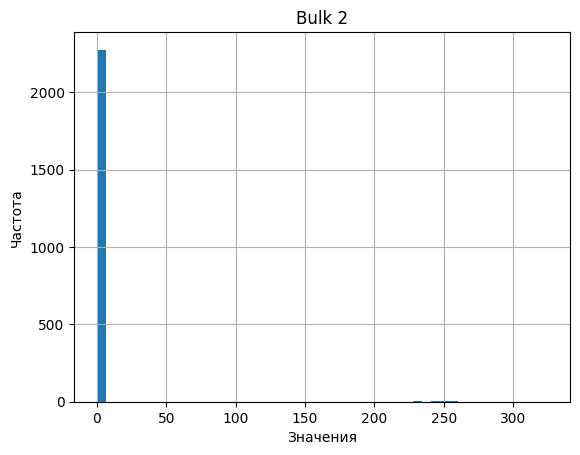

In [ ]:
plt.hist(df['Bulk 2'], bins=50)

plt.title('Bulk 2')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- Bulk 2 использовался еще меньше, но и значения объема тут значительнее, все больше 220

In [ ]:
df['Bulk 3'].value_counts()

Bulk 3
0.0      1340
21.0       26
19.0       25
23.0       13
44.0       13
         ... 
282.0       1
235.0       1
352.0       1
268.0       1
185.0       1
Name: count, Length: 263, dtype: int64

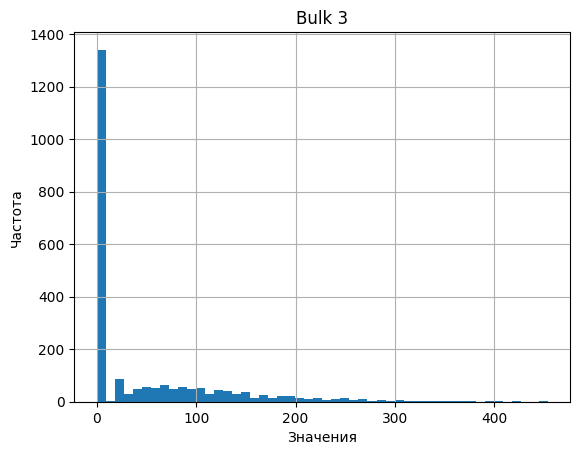

In [ ]:
plt.hist(df['Bulk 3'], bins=50)

plt.title('Bulk 3')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- Почти в половине случаев использовали Bulk 3
- Чаще всего использовали в малых объемах от 20 до 150

In [ ]:
df['Bulk 4'].value_counts()

Bulk 4
0.0      1492
21.0       17
105.0      16
106.0      14
116.0      13
         ... 
202.0       1
265.0       1
40.0        1
181.0       1
220.0       1
Name: count, Length: 199, dtype: int64

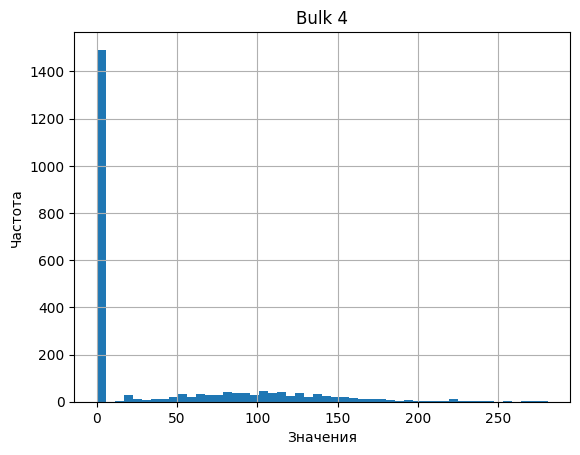

In [ ]:
plt.hist(df['Bulk 4'], bins=50)

plt.title('Bulk 4')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- Bulk 4 использовали только в трети случаев

In [ ]:
df['Bulk 5'].value_counts()

Bulk 5
0.0      2234
72.0        3
74.0        3
33.0        3
112.0       2
132.0       2
184.0       2
148.0       2
142.0       2
182.0       1
603.0       1
77.0        1
180.0       1
293.0       1
242.0       1
197.0       1
121.0       1
256.0       1
103.0       1
146.0       1
94.0        1
122.0       1
234.0       1
70.0        1
31.0        1
61.0        1
22.0        1
79.0        1
83.0        1
86.0        1
189.0       1
73.0        1
82.0        1
102.0       1
88.0        1
28.0        1
43.0        1
19.0        1
11.0        1
23.0        1
42.0        1
34.0        1
160.0       1
Name: count, dtype: int64

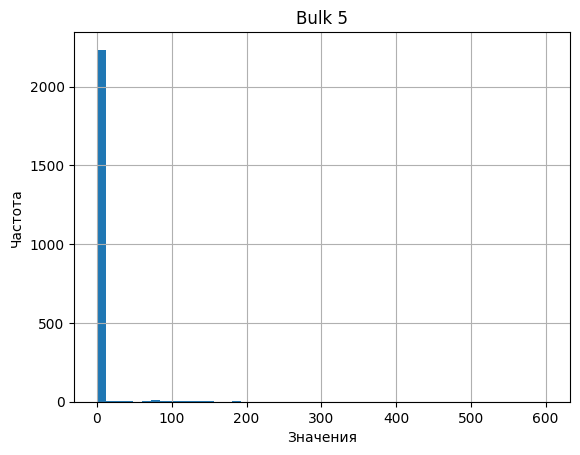

In [ ]:
plt.hist(df['Bulk 5'], bins=50)

plt.title('Bulk 5')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- Bulk 5 можно сказать почти не использовали, лишь в менее 100 случаев

In [ ]:
df['Bulk 6'].value_counts()

Bulk 6
0.0      1856
76.0       14
108.0       9
66.0        7
81.0        7
         ... 
176.0       1
156.0       1
206.0       1
112.0       1
357.0       1
Name: count, Length: 187, dtype: int64

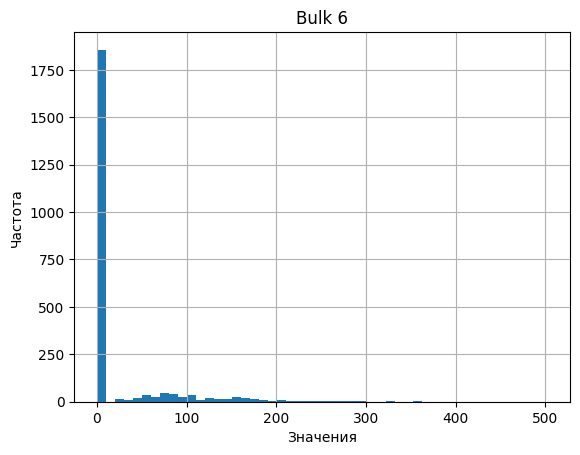

In [ ]:
plt.hist(df['Bulk 6'], bins=50)

plt.title('Bulk 6')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- Bulk 6 тоже использовался редко, меньше чем в трети случае

In [ ]:
df['Bulk 7'].value_counts()

Bulk 7
0.0      2274
178.0       1
406.0       1
75.0        1
155.0       1
252.0       1
92.0        1
772.0       1
576.0       1
306.0       1
392.0       1
507.0       1
553.0       1
405.0       1
Name: count, dtype: int64

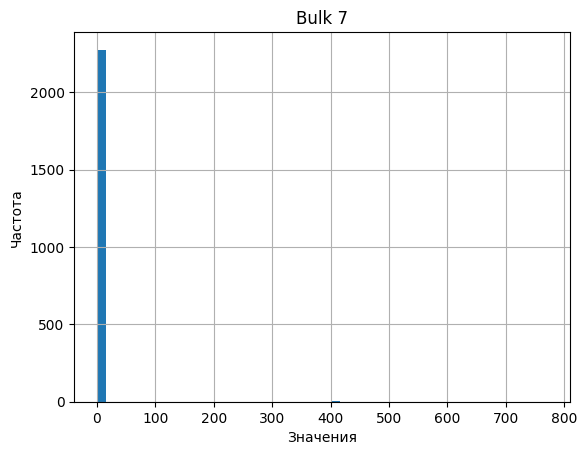

In [ ]:
plt.hist(df['Bulk 7'], bins=50)

plt.title('Bulk 7')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- Чуть больше 20 случаев использования Bulk 7

In [ ]:
df['Bulk 9'].value_counts()

Bulk 9
0.0      2274
66.0        3
65.0        2
70.0        2
63.0        1
68.0        1
71.0        1
147.0       1
111.0       1
108.0       1
Name: count, dtype: int64

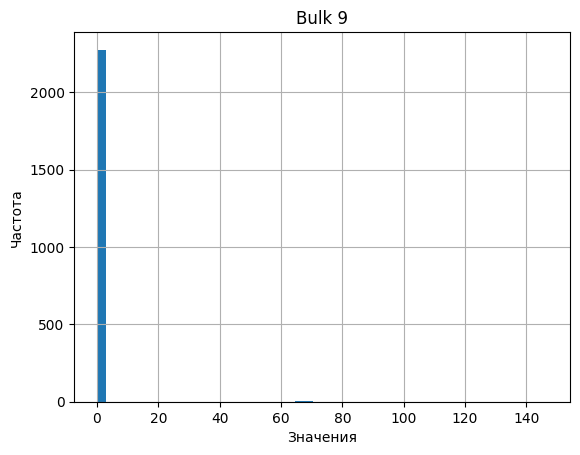

In [ ]:
plt.hist(df['Bulk 9'], bins=50)

plt.title('Bulk 9')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- Аналогично с предыдущим материалом

In [ ]:
df['Bulk 10'].value_counts()

Bulk 10
0.0      2145
105.0       8
88.0        6
56.0        6
75.0        6
         ... 
24.0        1
26.0        1
113.0       1
55.0        1
122.0       1
Name: count, Length: 70, dtype: int64

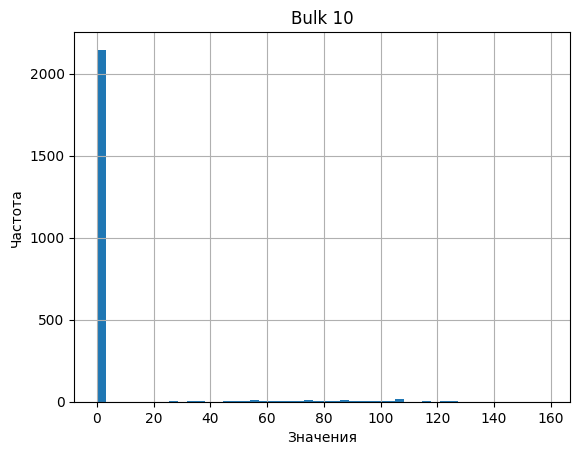

In [ ]:
plt.hist(df['Bulk 10'], bins=50)

plt.title('Bulk 10')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- Мнее 200 раз использовали Bulk 10

In [ ]:
df['Bulk 11'].value_counts()

Bulk 11
0.0     2161
19.0       6
17.0       6
25.0       5
49.0       4
        ... 
82.0       1
98.0       1
66.0       1
71.0       1
24.0       1
Name: count, Length: 82, dtype: int64

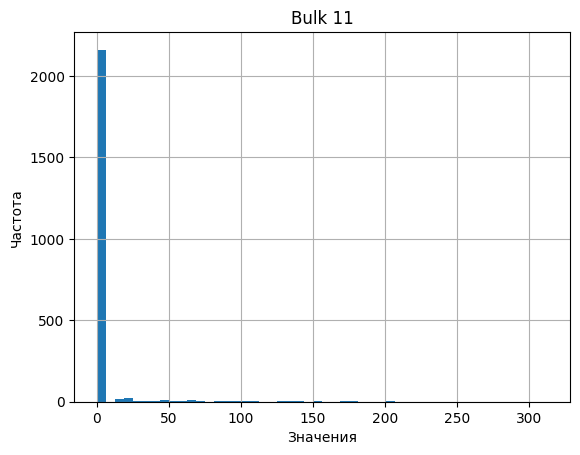

In [ ]:
plt.hist(df['Bulk 11'], bins=50)

plt.title('Bulk 11')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- Аналогично с предыдущим материалом

In [ ]:
df['Bulk 12'].value_counts()

Bulk 12
0.0      507
206.0    187
205.0    134
207.0     92
204.0     75
        ... 
392.0      1
385.0      1
182.0      1
303.0      1
266.0      1
Name: count, Length: 301, dtype: int64

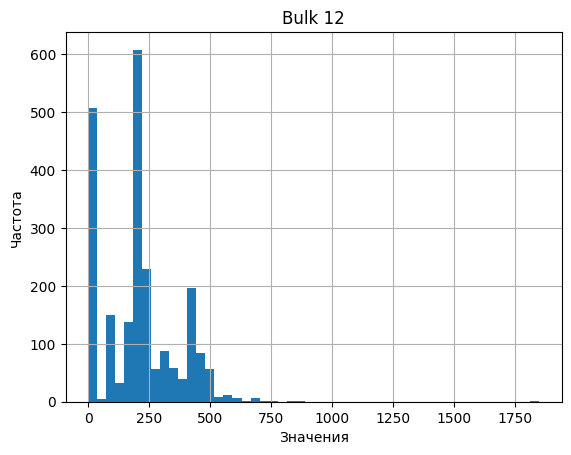

In [ ]:
plt.hist(df['Bulk 12'], bins=50)

plt.title('Bulk 12')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- Bulk 12 использовался чаще других материалов, при чем иногда в очень больших объемах
- Максимальный объем при использовании около 1800
- Минимальный объем около 50
- В среднем объем около 250

In [ ]:
df['Bulk 13'].value_counts()

Bulk 13
0.0      2273
154.0       3
153.0       3
159.0       1
278.0       1
155.0       1
157.0       1
204.0       1
151.0       1
305.0       1
156.0       1
Name: count, dtype: int64

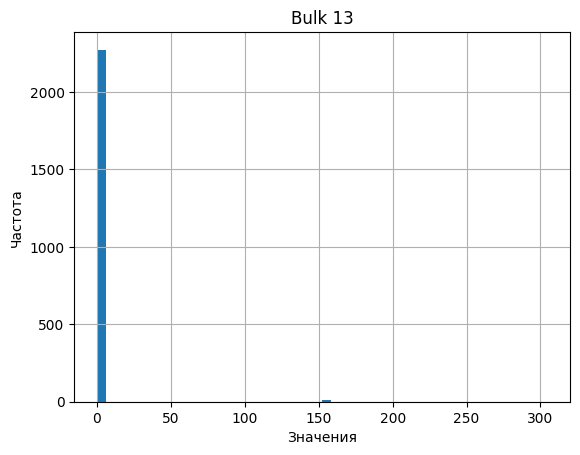

In [ ]:
plt.hist(df['Bulk 13'], bins=50)

plt.title('Bulk 13')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- Bulk 13 использовался лиш в некоторых случаях, менее 20 раз

In [ ]:
df['Bulk 14'].value_counts()

Bulk 14
0.0      256
99.0      58
104.0     47
102.0     46
149.0     45
        ... 
337.0      1
161.0      1
173.0      1
167.0      1
269.0      1
Name: count, Length: 253, dtype: int64

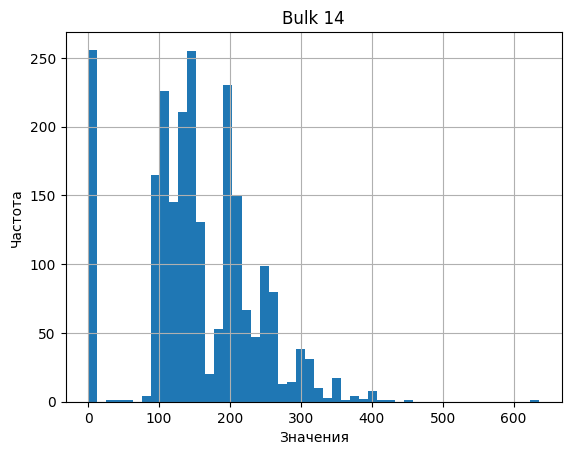

In [ ]:
plt.hist(df['Bulk 14'], bins=50)

plt.title('Bulk 14')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- Bulk 14 как и Bulk 12 использовался чаще других материалов и даже больше чем Bulk 12
- Однако объемы меньше: максимальное около 650, минимальное окло 20
- В среднем объем составляет около 200
- Не использовался этот материал всего в 312 случаях из 3000

In [ ]:
df['Bulk 15'].value_counts()

Bulk 15
0.0      618
204.0    165
205.0    145
203.0    144
104.0    139
        ... 
192.0      1
260.0      1
168.0      1
261.0      1
229.0      1
Name: count, Length: 143, dtype: int64

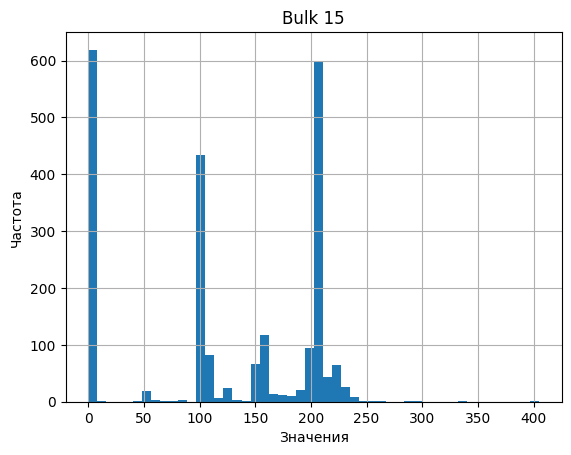

In [ ]:
plt.hist(df['Bulk 15'], bins=50)

plt.title('Bulk 15')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- Bulk 15 тоже использовался относительно часто, в более чем 2/3 случаев
- Максмиальный объем при использовании составляет 400
- Минимальный около 10
- В среднем объем около 150

Если суммировать результаты по анализу материала Bulk, то можно выделить следующие тезисы:
- Большинство материалов используется редко
- Чаще всего используется материал Bulk 12, 14, 15
- В среднем объем материала при использовании составляет около 200
- Переходим к следующему столбцу

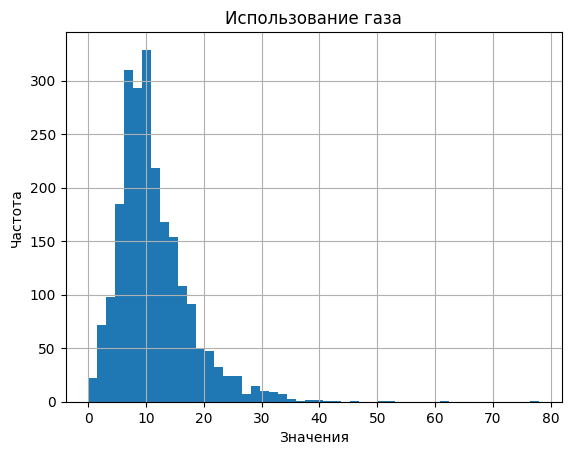

In [ ]:
plt.hist(df['gas'], bins=50)

plt.title('Использование газа')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

In [ ]:
df['gas'].describe()

count    2287.000000
mean       11.394856
std         6.399461
min         0.008399
25%         7.301535
50%        10.105480
75%        14.222380
max        77.995040
Name: gas, dtype: float64

- Среднее значение 11.2
- Максимальное 78
- Минимальное 0.008
- Медиана 10

Далее идут столбцы MesaureTime_first и MesaureTime_last, в которых указано время первого замера температуры и последнего замера. Сами по себе они ничего не дадут. Как вариант получить признак диапазона времени между замерами, а сами столбцы удалить.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2287 entries, 0 to 10749
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2287 non-null   int64  
 1   ActivePower        2287 non-null   float64
 2   ReactivePower      2287 non-null   float64
 3   Duration           2287 non-null   float64
 4   AllPower           2287 non-null   float64
 5   TotalPower         2287 non-null   float64
 6   Bulk 1             2287 non-null   float64
 7   Bulk 2             2287 non-null   float64
 8   Bulk 3             2287 non-null   float64
 9   Bulk 4             2287 non-null   float64
 10  Bulk 5             2287 non-null   float64
 11  Bulk 6             2287 non-null   float64
 12  Bulk 7             2287 non-null   float64
 13  Bulk 9             2287 non-null   float64
 14  Bulk 10            2287 non-null   float64
 15  Bulk 11            2287 non-null   float64
 16  Bulk 12            2287 non-

In [ ]:
df['MesaureTime_diff'] = df['MesaureTime_last'] - df['MesaureTime_first']

In [ ]:
df['MesaureTime_diff'] = df['MesaureTime_diff'].apply(lambda x: pd.Timedelta(x).total_seconds())

In [ ]:
df = df.drop(['MesaureTime_last', 'MesaureTime_first'], axis=1)

- Добавил новый столбец MesaureTime_diff, в котором хранится промежуток между первым и последним замером температуры в секундах
- Столбцы MesaureTime_last и MesaureTime_first удалил
- Проанализируем новый столбец

In [ ]:
df['MesaureTime_diff'].describe()

count     2287.000000
mean      3794.702667
std      12572.026986
min        234.000000
25%       1223.500000
50%       1653.000000
75%       2334.500000
max      86192.000000
Name: MesaureTime_diff, dtype: float64

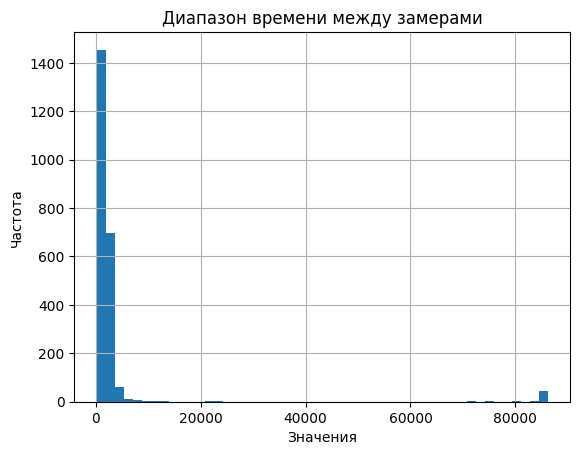

In [ ]:
plt.hist(df['MesaureTime_diff'], bins=50)

plt.title('Диапазон времени между замерами')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- Самое большое значение между замерами равно почти суткам
- Минимальное время между замерами равно 0
- И то и другое выглядит скорее как аномалия, но если сутки при большом объеме еще могут в теории быть, то 0 точно нет
- Посморим на аномалии поближе

In [ ]:
null_diff = df[df['MesaureTime_diff'] == 0]
null_diff

,key,ActivePower,ReactivePower,Duration,AllPower,TotalPower,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,MesaureTime_diff


- Всего 1 строка, заменим на среднее время

In [ ]:
df.loc[df['MesaureTime_diff'] == 0] = df['MesaureTime_diff'].mean()

In [ ]:
null_diff = df[df['MesaureTime_diff'] > 80000]
null_diff

,key,ActivePower,ReactivePower,Duration,AllPower,TotalPower,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,MesaureTime_diff
79,18,0.415692,0.328181,125.0,0.743873,5.882601,0.0,0.0,0.0,0.0,...,88.233596,32.148487,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,86136.0
190,44,0.514491,0.406311,146.0,0.920802,13.474597,0.0,0.0,0.0,0.0,...,69.189123,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,80095.0
202,45,0.667737,0.554781,195.0,1.222518,15.747997,0.0,0.0,0.0,0.0,...,114.354237,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,84437.0
212,46,0.416553,0.312153,102.0,0.728706,20.731517,0.0,0.0,0.0,0.0,...,100.245593,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,83568.0
311,74,0.449316,0.357174,132.0,0.806490,6.053164,0.0,0.0,0.0,188.0,...,117.280792,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,85778.0
425,104,0.571722,0.402108,160.0,0.973830,3.197129,0.0,0.0,0.0,0.0,...,65.170555,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,85684.0
509,126,0.447879,0.344112,132.0,0.791991,6.423966,0.0,0.0,69.0,0.0,...,56.085118,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,86131.0
973,232,0.449821,0.371289,134.0,0.821110,7.586211,0.0,0.0,0.0,0.0,...,145.017593,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,85815.0
1068,257,0.397005,0.292473,120.0,0.689479,2.205972,0.0,0.0,0.0,26.0,...,84.171356,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,86079.0
1162,280,0.531808,0.432575,159.0,0.964384,12.484916,0.0,0.0,126.0,0.0,...,160.174557,76.236166,0.0,0.0,0.0,0.0,0.0,46.002319,0.000000,85875.0


- Сложно понять с чем могут быть связаны такие большие значения, пока оставим как есть, возмодно дело в больших объемах

In [ ]:
df['MesaureTime_diff'].describe()

count     2287.000000
mean      3794.702667
std      12572.026986
min        234.000000
25%       1223.500000
50%       1653.000000
75%       2334.500000
max      86192.000000
Name: MesaureTime_diff, dtype: float64

- Избавились от явной аномалии равной 0
- Высокие значения пока оставили
- Максимальное значение 86213 секунд (23.9 часов)
- Минимальное значение 197 секунд (около 3 минут)
- Среднее время между первым и последним замерами 1641 секунда (27 минут)
- Переходим к следующему столбцу

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2287 entries, 0 to 10749
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2287 non-null   int64  
 1   ActivePower        2287 non-null   float64
 2   ReactivePower      2287 non-null   float64
 3   Duration           2287 non-null   float64
 4   AllPower           2287 non-null   float64
 5   TotalPower         2287 non-null   float64
 6   Bulk 1             2287 non-null   float64
 7   Bulk 2             2287 non-null   float64
 8   Bulk 3             2287 non-null   float64
 9   Bulk 4             2287 non-null   float64
 10  Bulk 5             2287 non-null   float64
 11  Bulk 6             2287 non-null   float64
 12  Bulk 7             2287 non-null   float64
 13  Bulk 9             2287 non-null   float64
 14  Bulk 10            2287 non-null   float64
 15  Bulk 11            2287 non-null   float64
 16  Bulk 12            2287 non-

In [ ]:
df['Temperature_first'].describe()

count    2287.000000
mean     1587.219939
std        23.617267
min      1519.000000
25%      1571.000000
50%      1587.000000
75%      1603.000000
max      1660.000000
Name: Temperature_first, dtype: float64

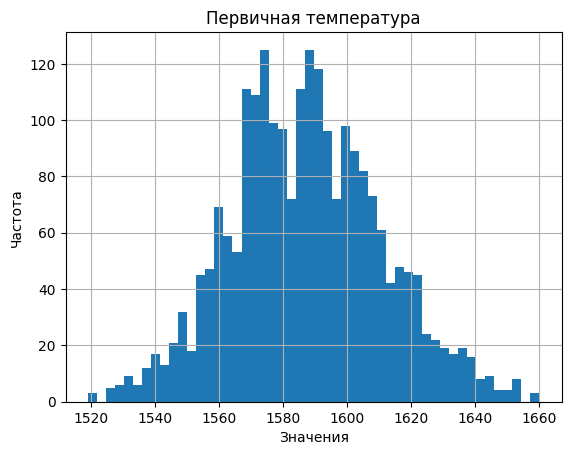

In [ ]:
plt.hist(df['Temperature_first'], bins=50)

plt.title('Первичная температура')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- Среднее значение 1587
- Минимальное 1519
- Максимальное 1660
- Переходим к следующему столбцу с целевой переменной

In [ ]:
df['Temperature_last'].describe()

count    2287.000000
mean     1593.166157
std        11.450813
min      1530.000000
25%      1587.000000
50%      1593.000000
75%      1598.000000
max      1653.000000
Name: Temperature_last, dtype: float64

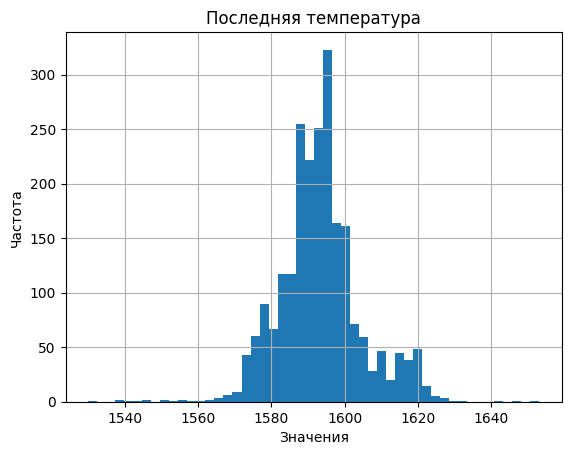

In [ ]:
plt.hist(df['Temperature_last'], bins=50)

plt.title('Последняя температура')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- Среднее чуть выше: 1593
- Минимальное 1530
- Максимальное 1653
- Глобально я бы не сказал, что температурные значения сильно сдвинулись, это говорит о том, что первичная температура в некоторых случаях совпадает с конечной
- Осталось просмотреть столбцы с материалом Wire

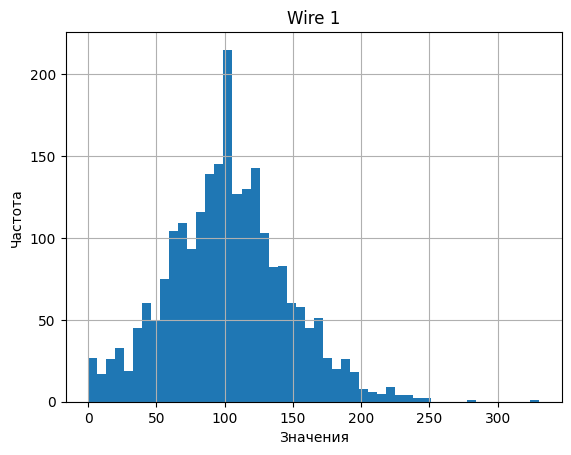

In [ ]:
plt.hist(df['Wire 1'], bins=50)

plt.title('Wire 1')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- Wire 1 имеет явное среднее значение около 100
- Глобально материал использовался почти всегда

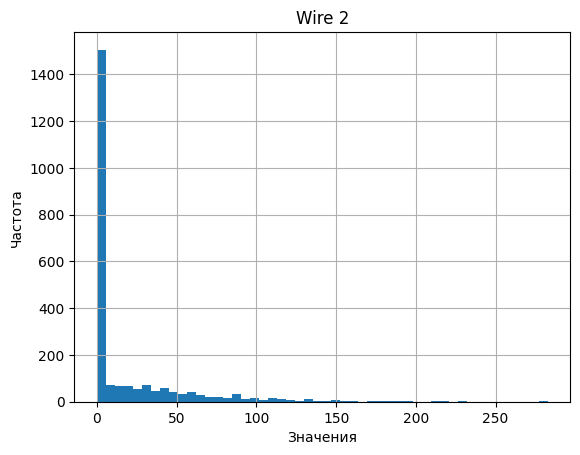

In [ ]:
plt.hist(df['Wire 2'], bins=50)

plt.title('Wire 2')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- Wire 2 использовался только в 1/3 случаев
- Среднее значение объема около 50

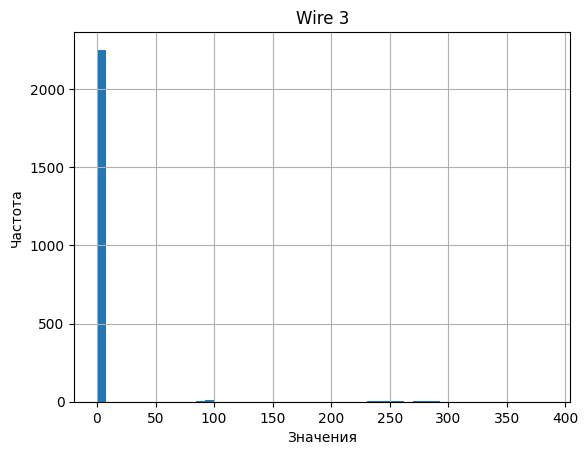

In [ ]:
plt.hist(df['Wire 3'], bins=50)

plt.title('Wire 3')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- Wire 3 почти не использовали

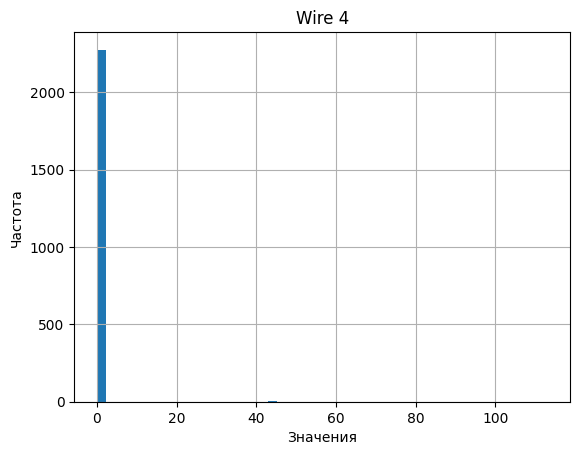

In [ ]:
plt.hist(df['Wire 4'], bins=50)

plt.title('Wire 4')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- Аналогично с предыдущим материалом

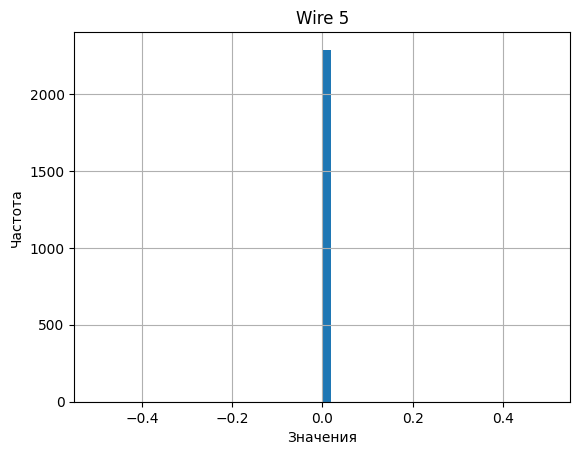

In [ ]:
plt.hist(df['Wire 5'], bins=50)

plt.title('Wire 5')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

In [ ]:
df['Wire 5'].value_counts()

Wire 5
0.0    2287
Name: count, dtype: int64

- Wire 5 использовался только 1 раз

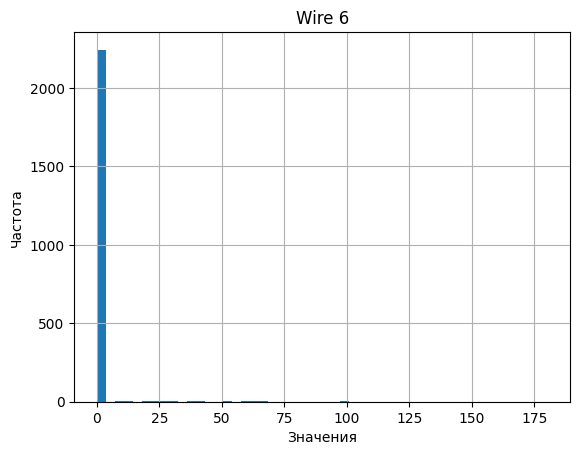

In [ ]:
plt.hist(df['Wire 6'], bins=50)

plt.title('Wire 6')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- Wire 6 почти не использовался

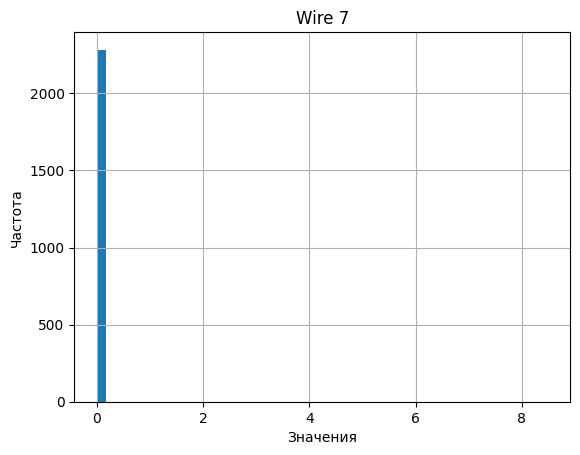

In [ ]:
plt.hist(df['Wire 7'], bins=50)

plt.title('Wire 7')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- Аналогично с предыдущим материалом

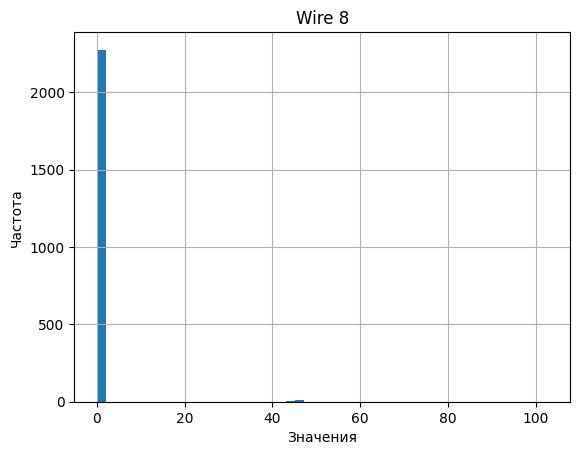

In [ ]:
plt.hist(df['Wire 8'], bins=50)

plt.title('Wire 8')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- Аналогично с предыдущим материалом

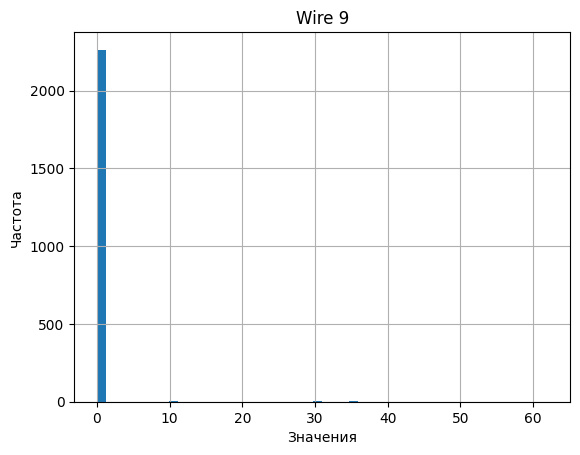

In [ ]:
plt.hist(df['Wire 9'], bins=50)

plt.title('Wire 9')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

- То же самое, материал почти не использовали

Если суммировать, то:
- Почти всегда использоваося Wire 1 и иногда Wire 2.
- Совсем редко остальные материалы.
- Wire 5 вообще использовался только 1 раз.

Можно переходить к корреляционному анализу

In [ ]:
def plot_feature_correlations(df):
    corr_matrix = df.corr()

    for feature in df.columns:
        plt.figure(figsize=(10, 6))
        plt.bar(corr_matrix[feature].index, corr_matrix[feature].values)
        plt.title(f'Корреляция "{feature}"')
        plt.xlabel('Признак')
        plt.ylabel('Коэффициент корреляции')
        plt.grid()
        plt.xticks(rotation=90)
        plt.show()


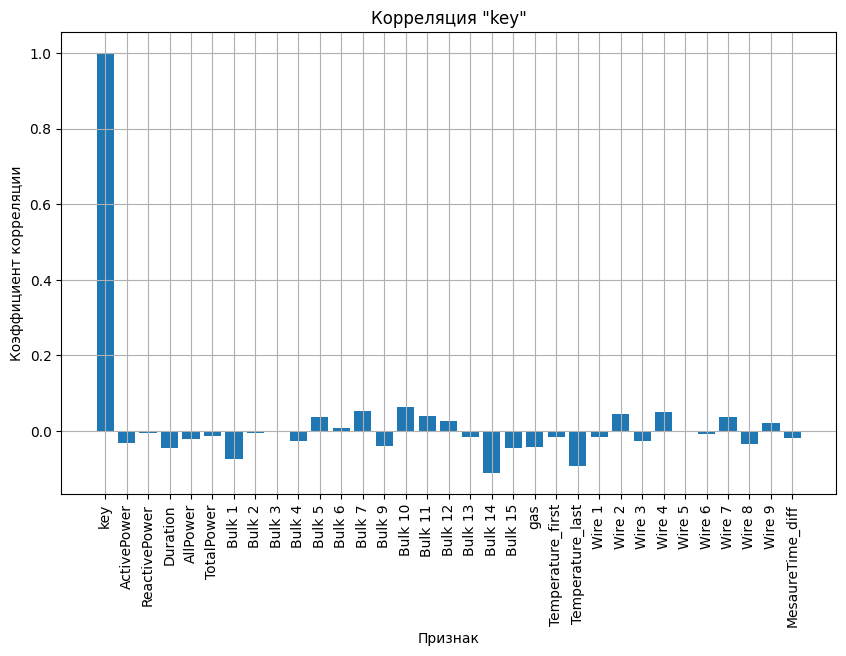

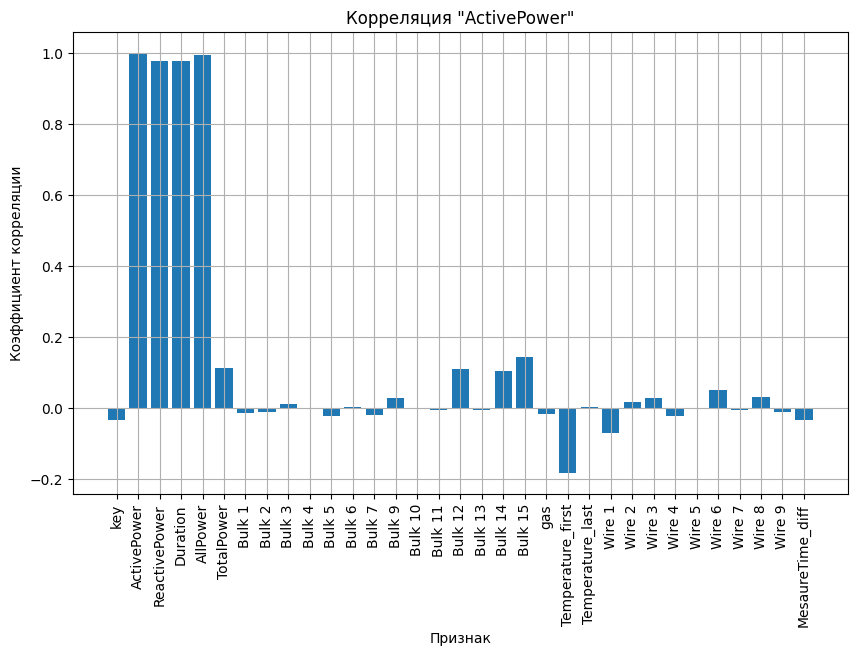

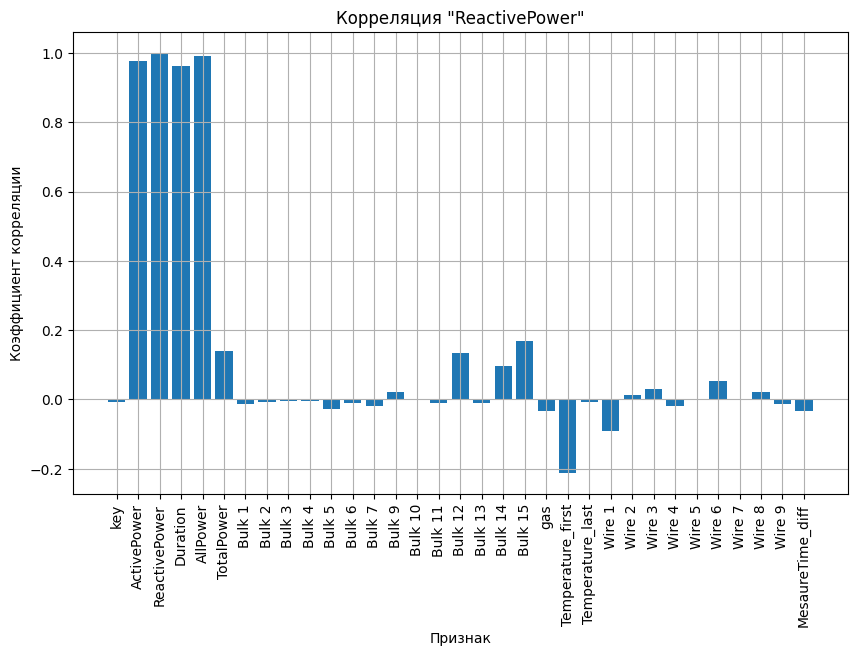

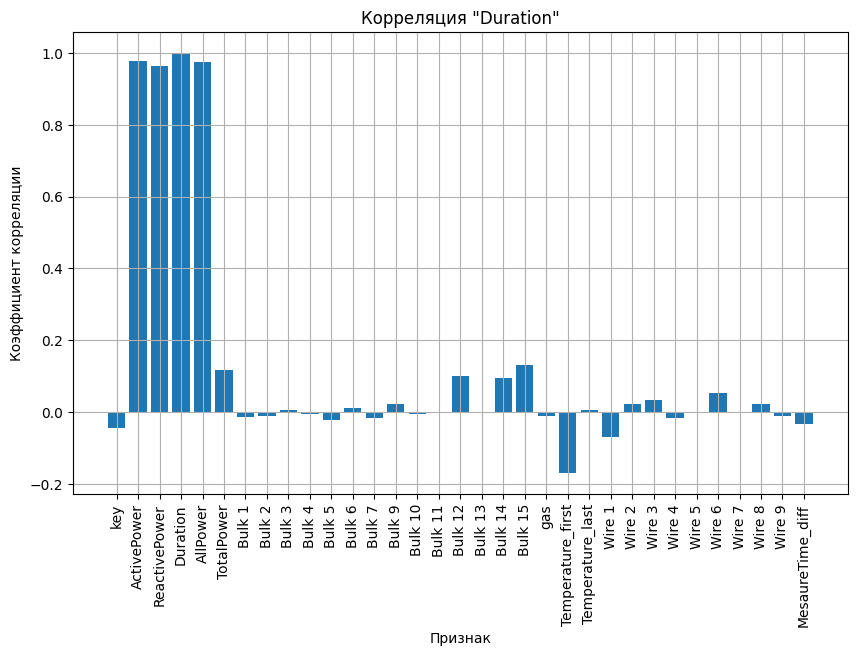

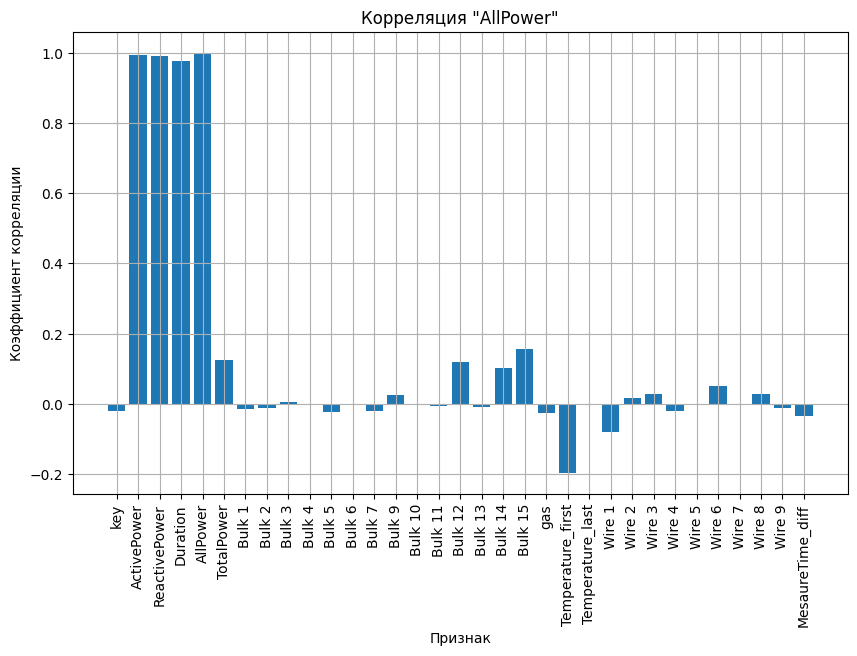

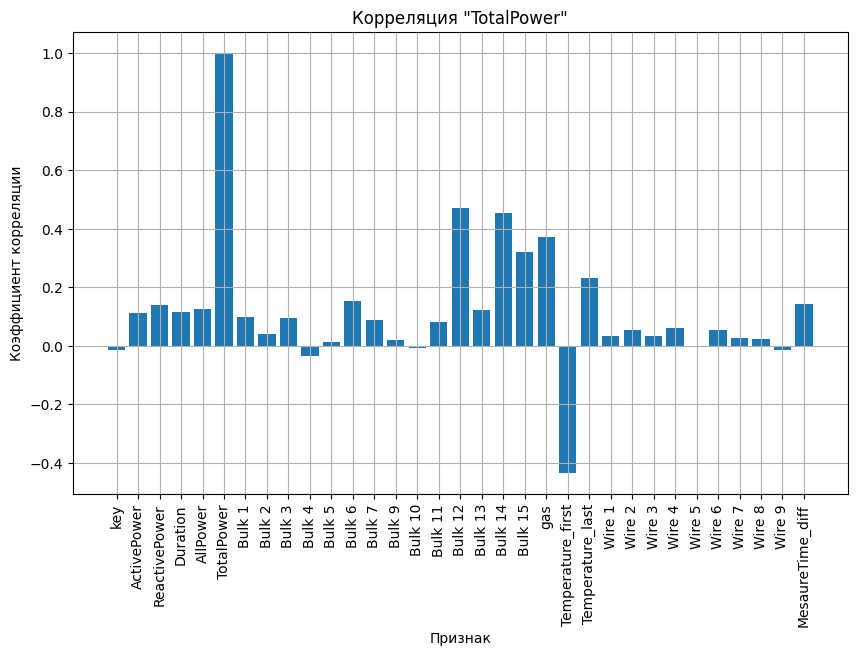

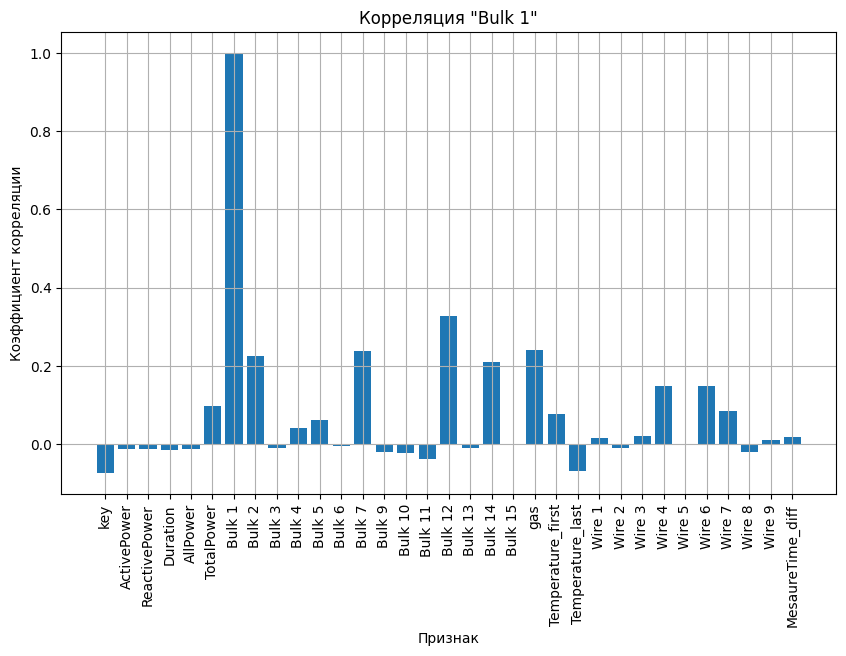

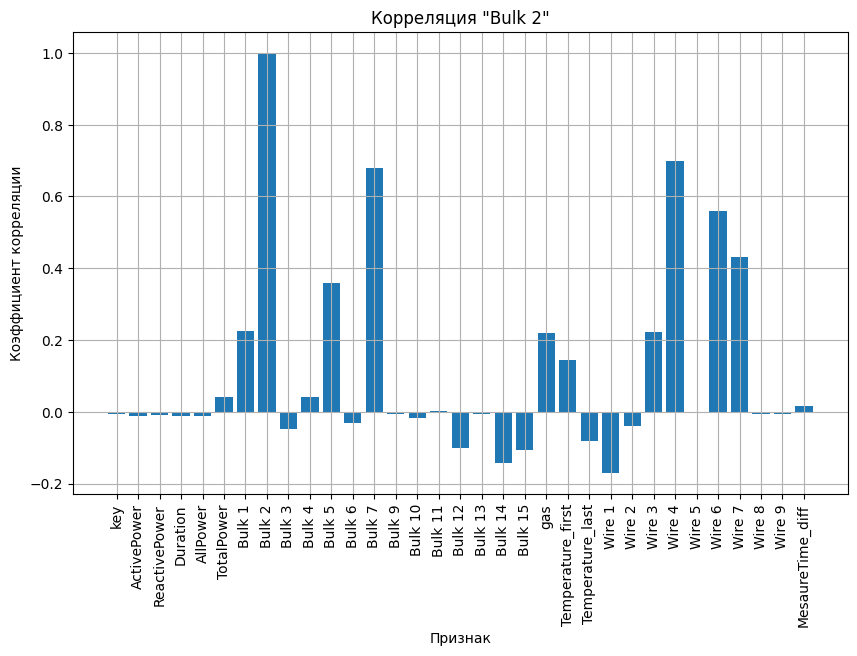

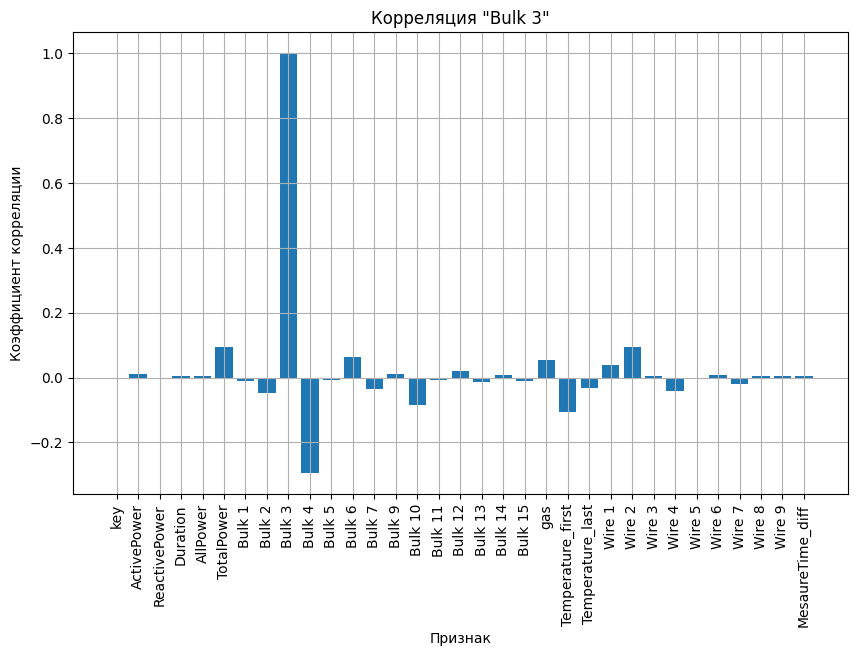

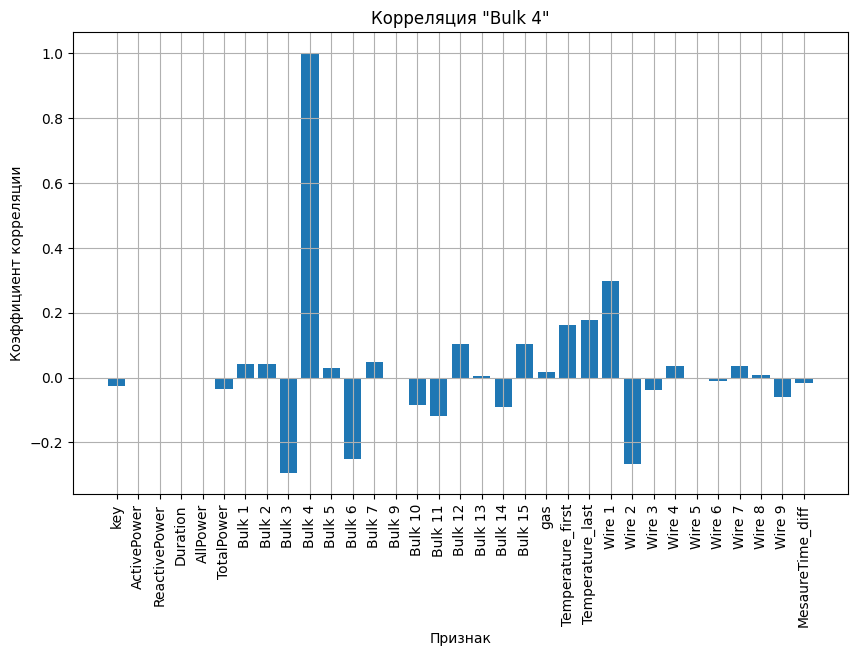

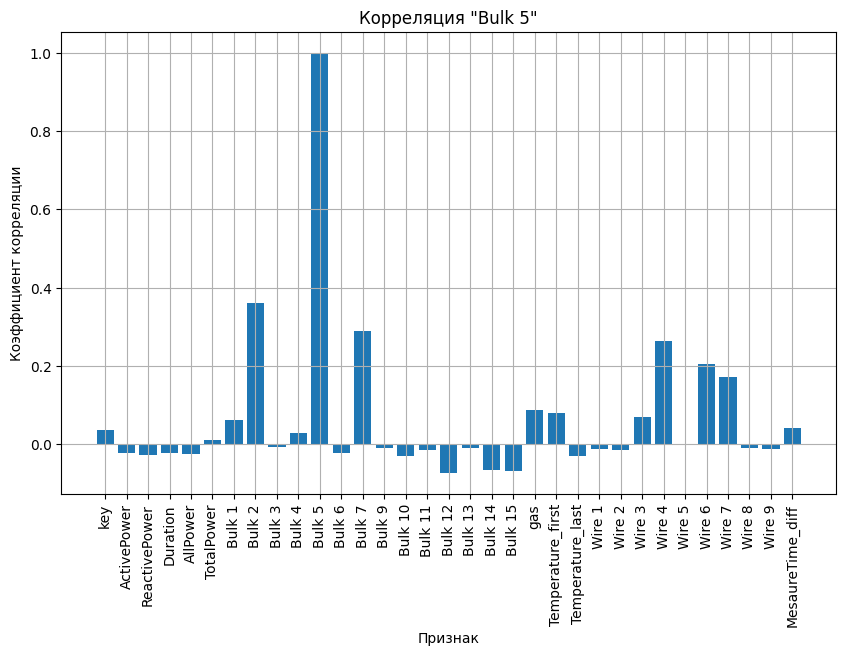

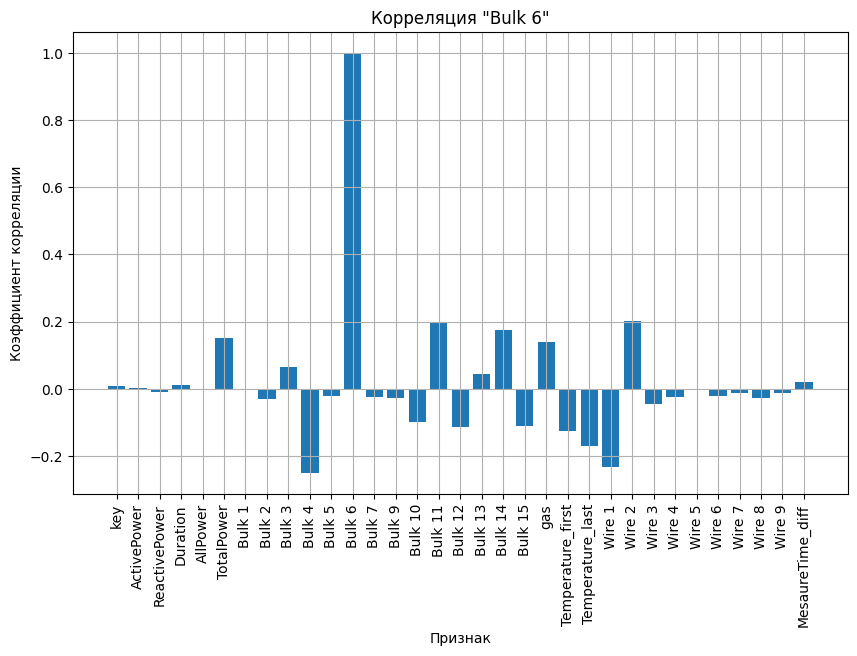

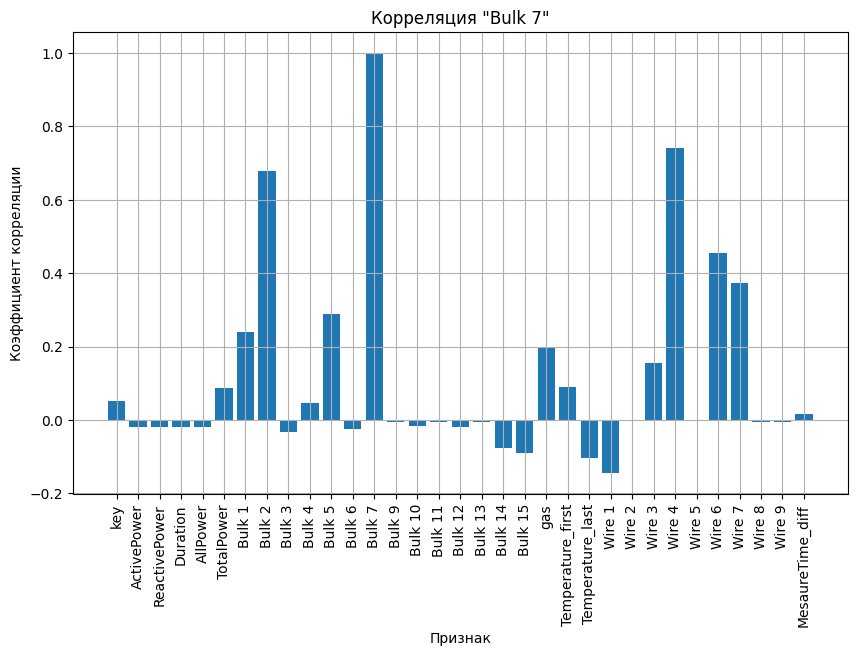

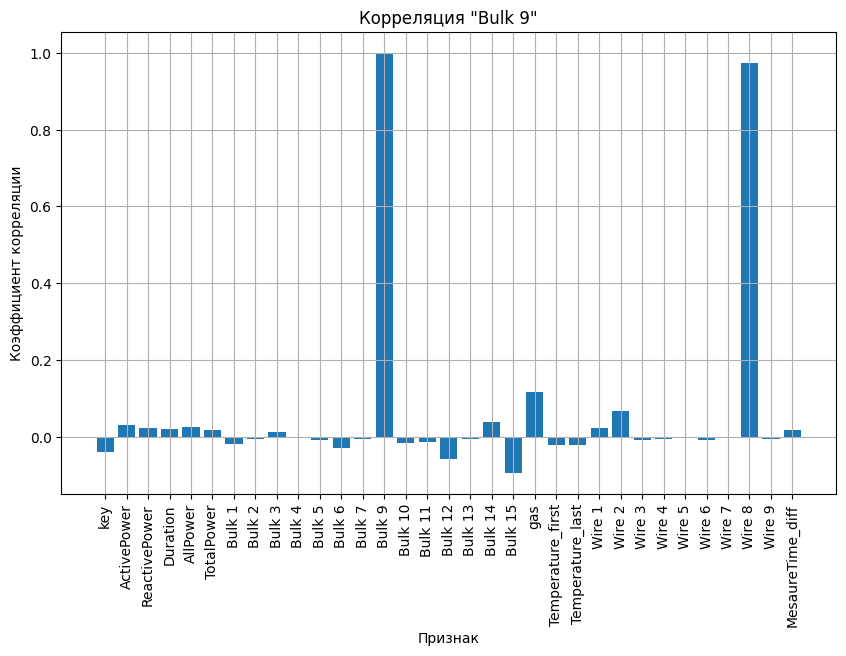

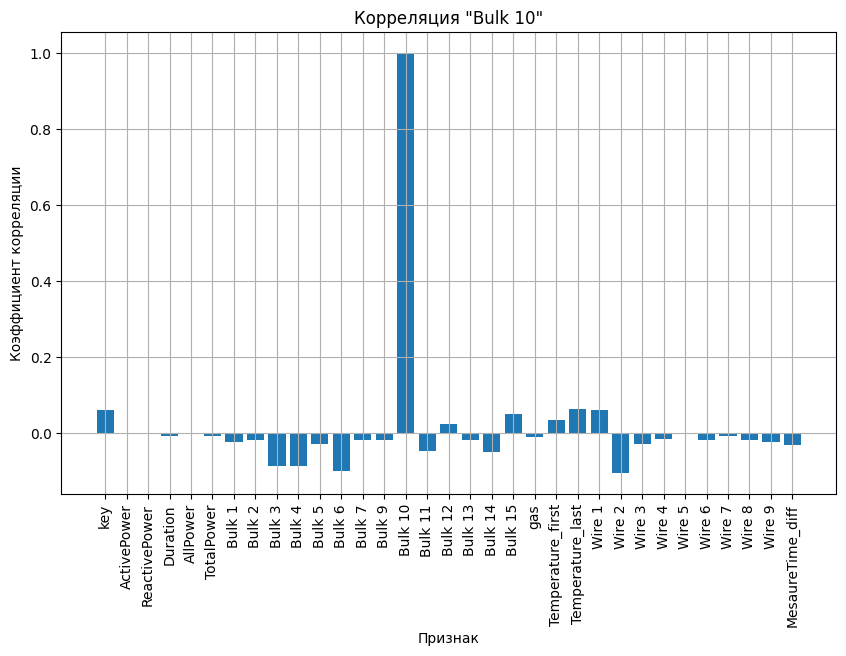

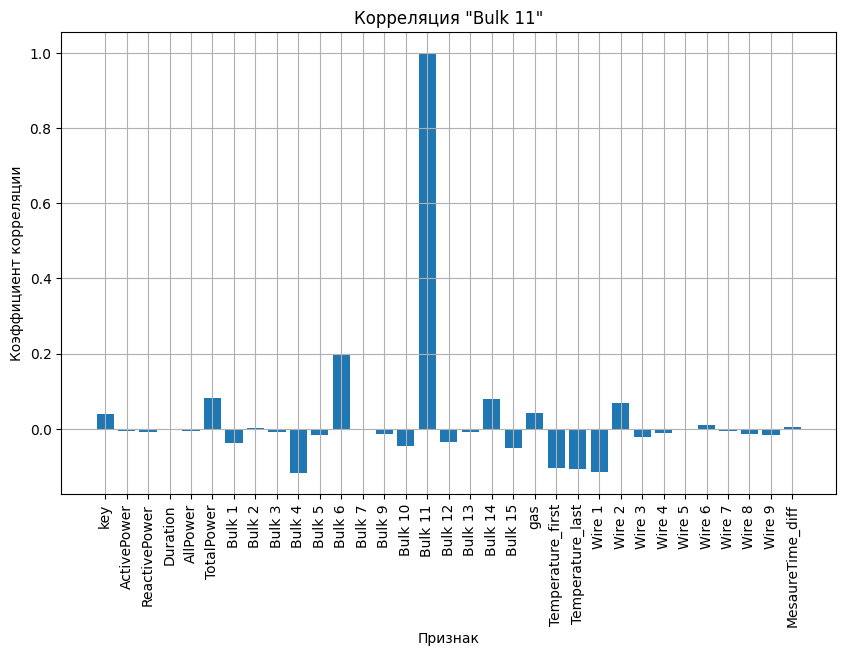

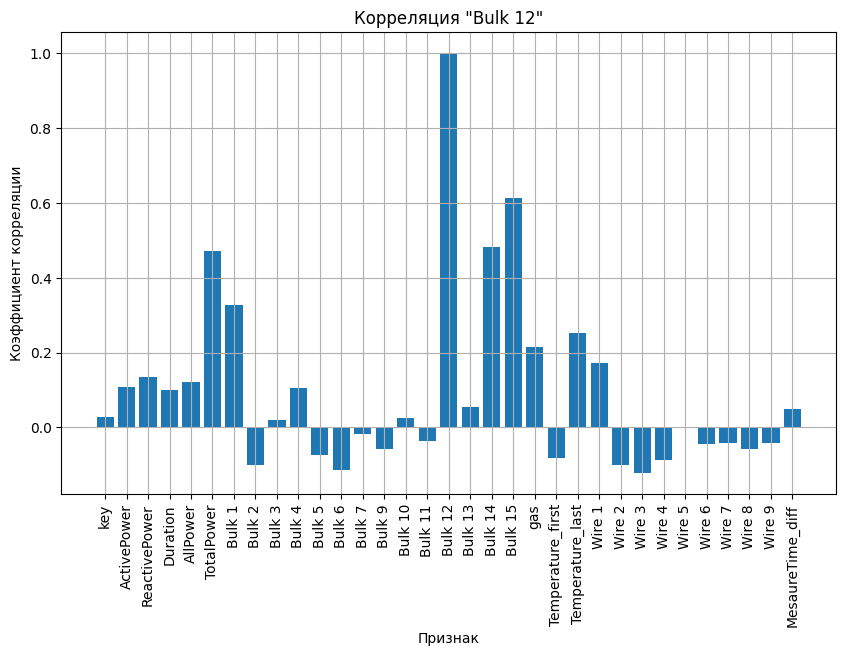

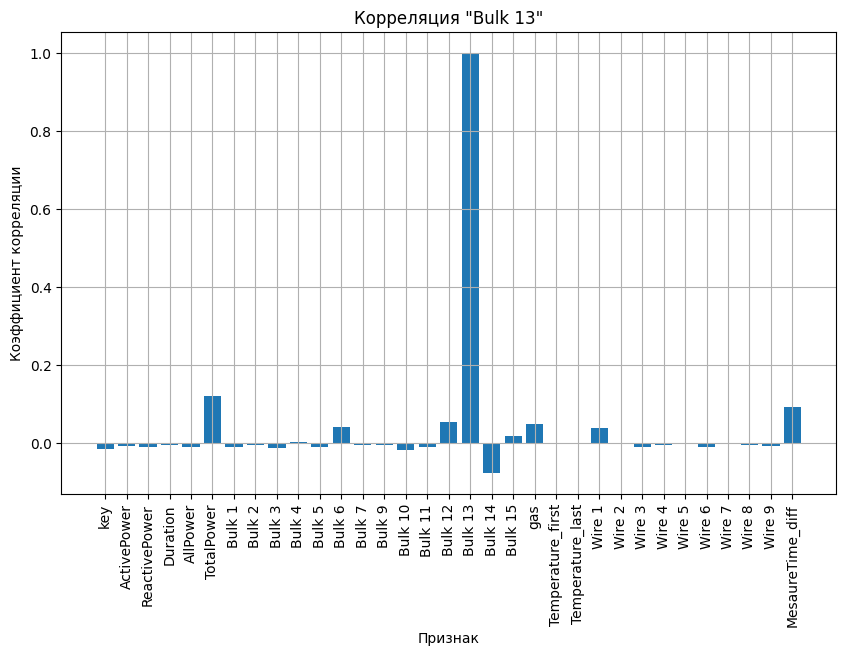

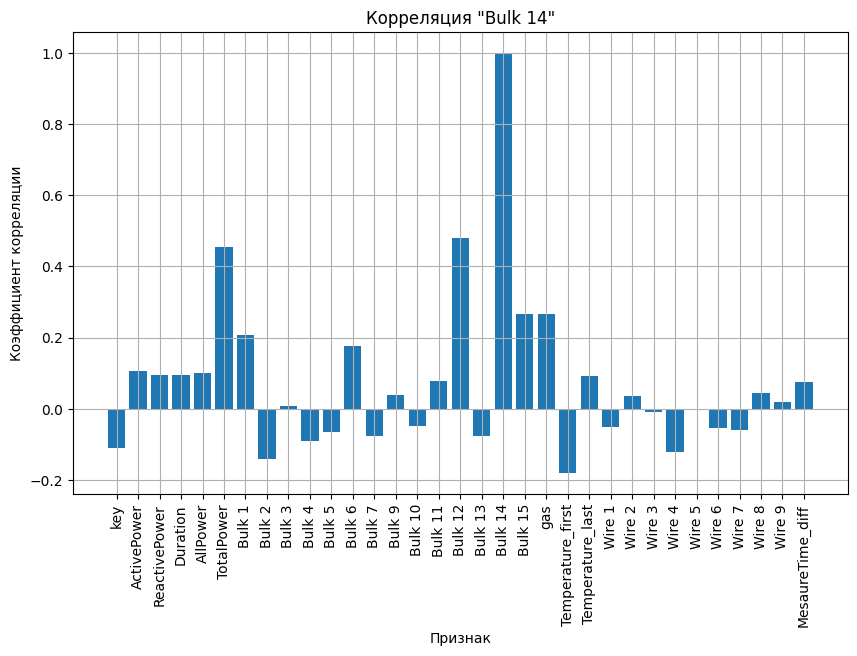

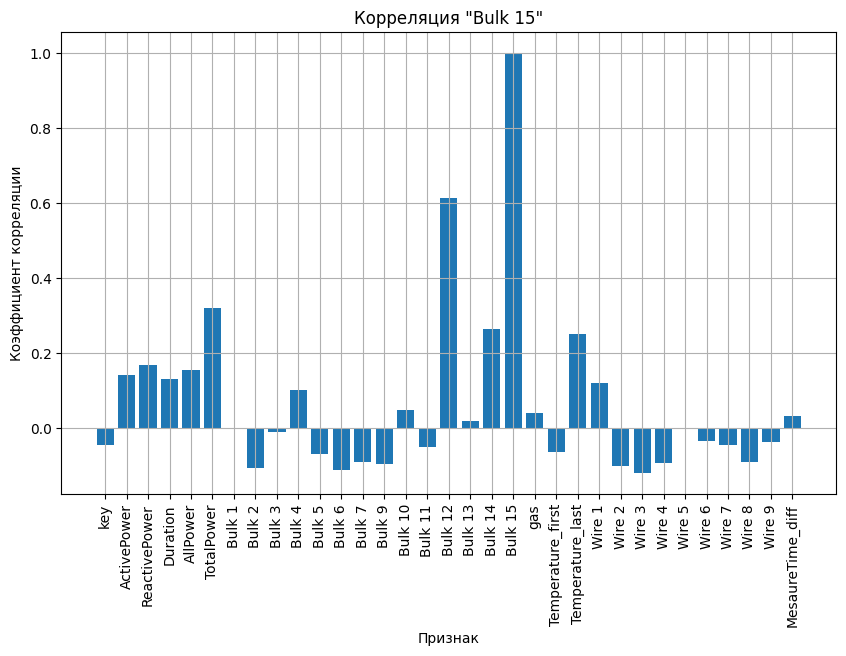

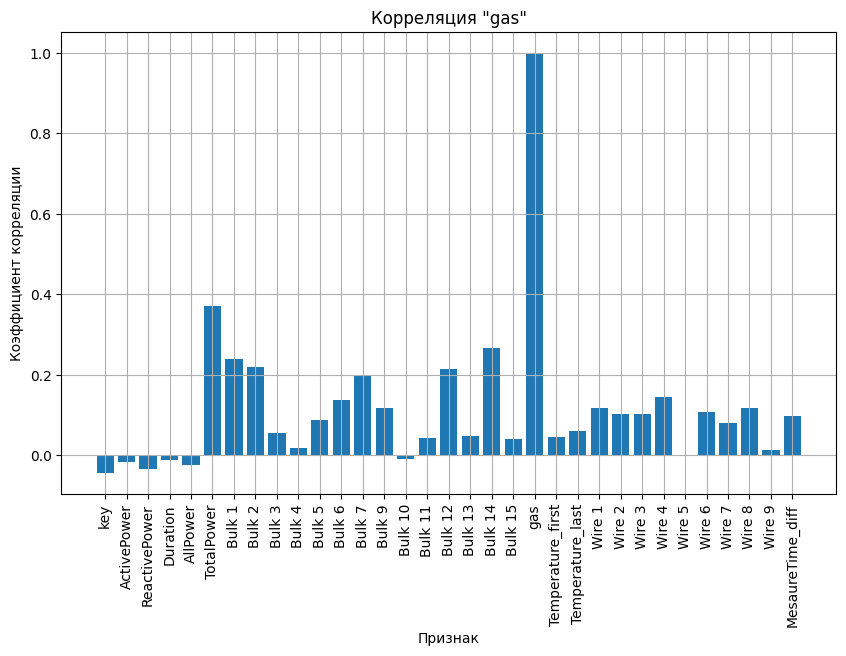

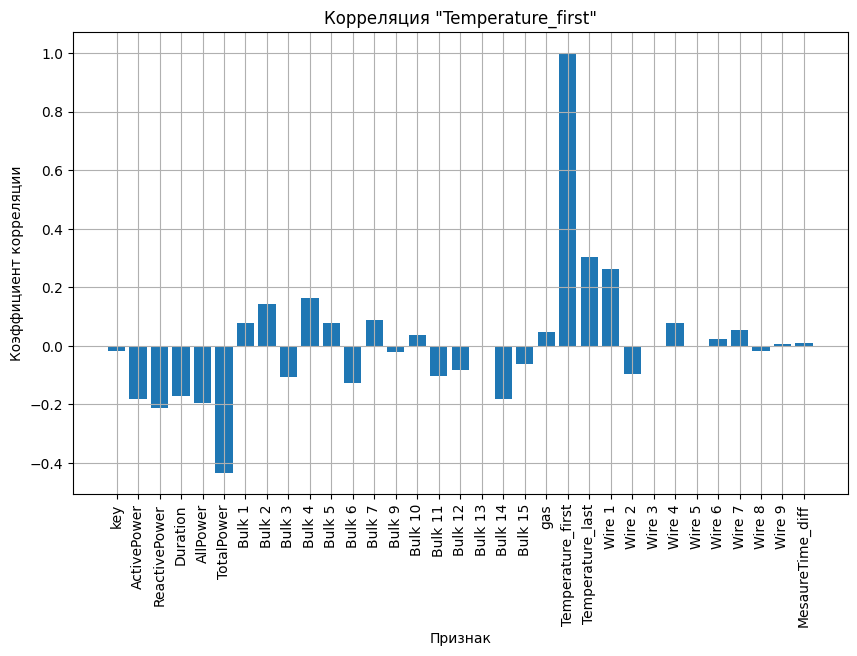

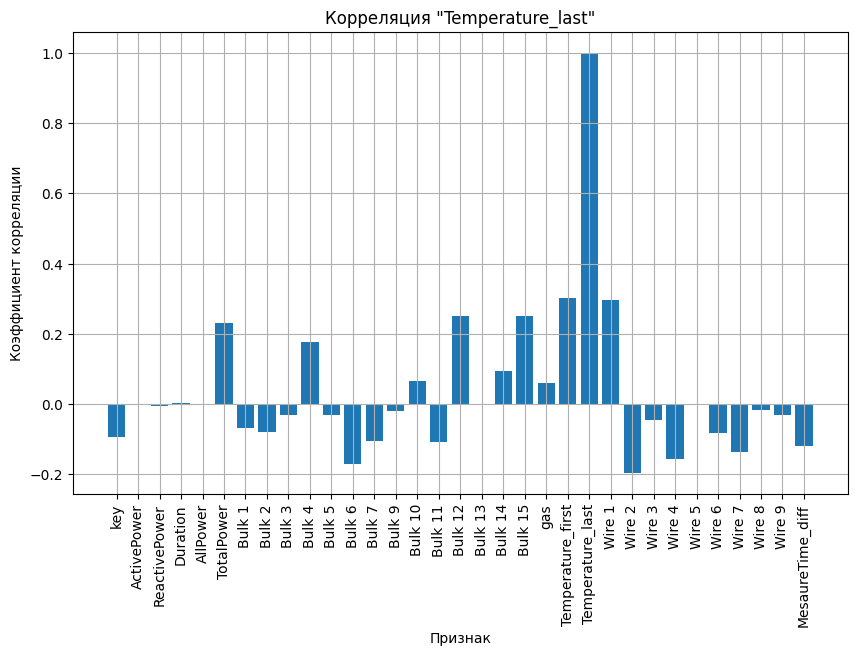

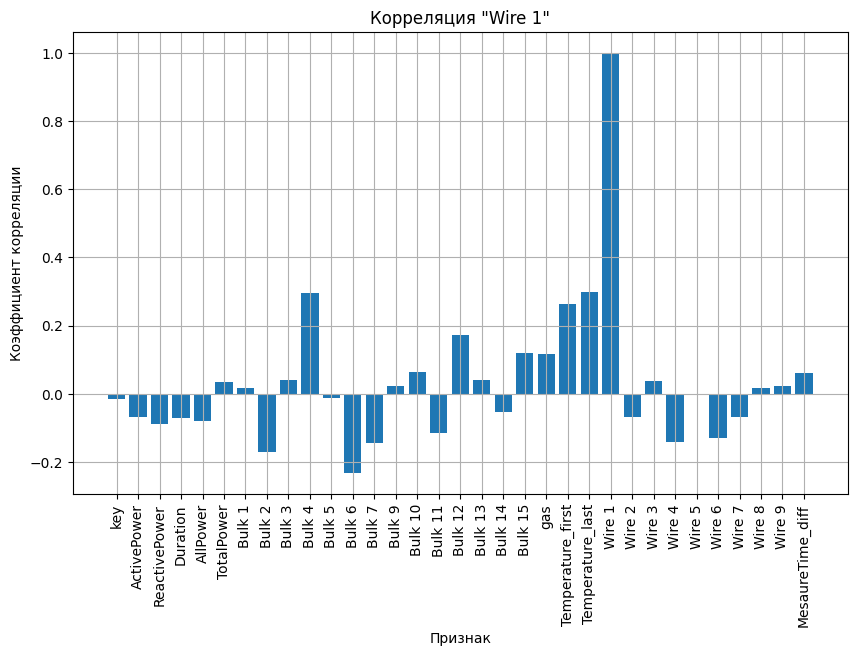

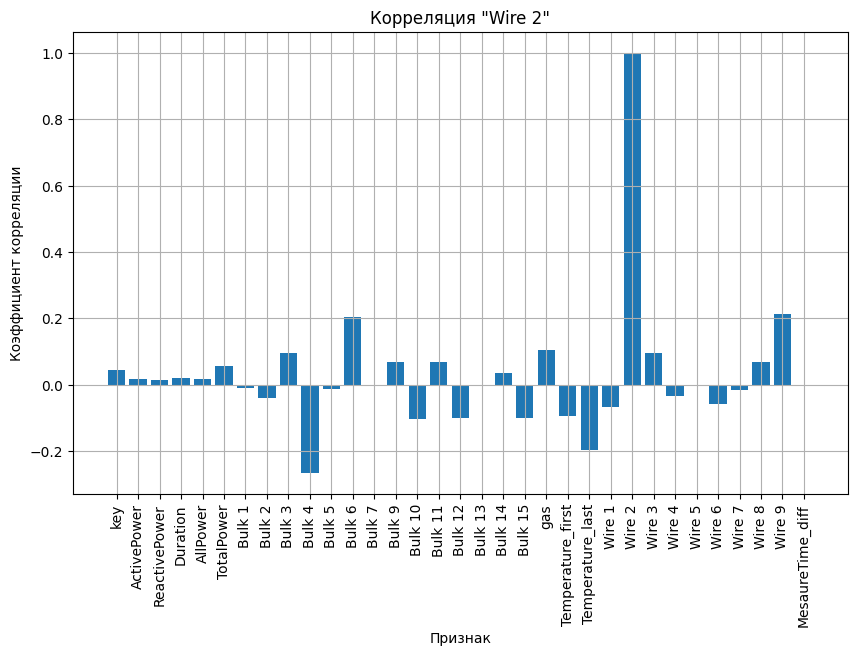

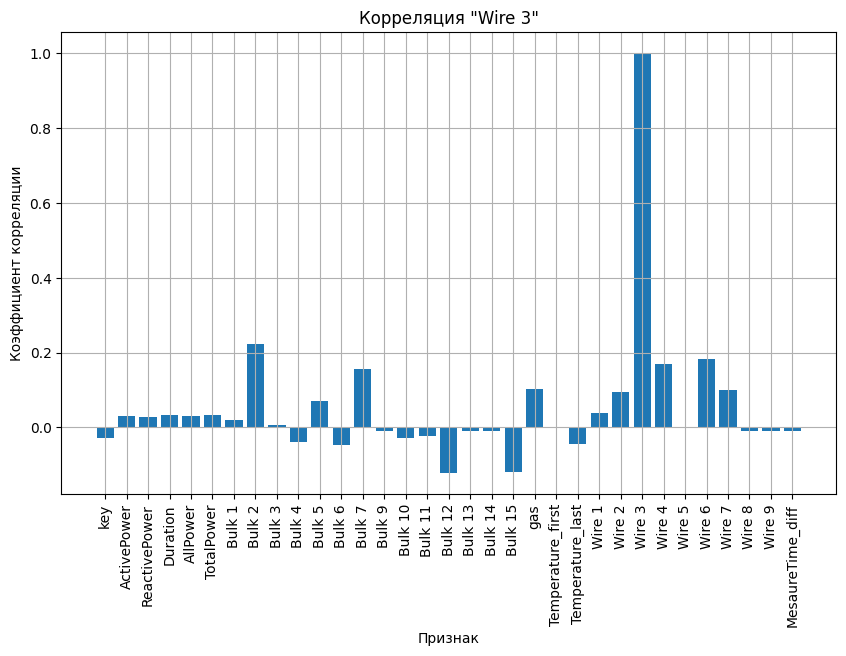

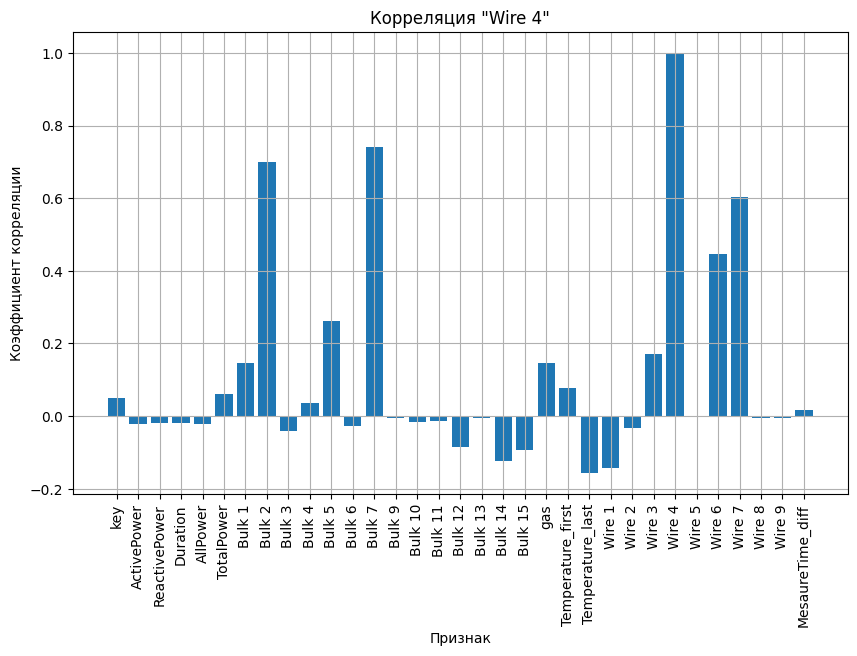

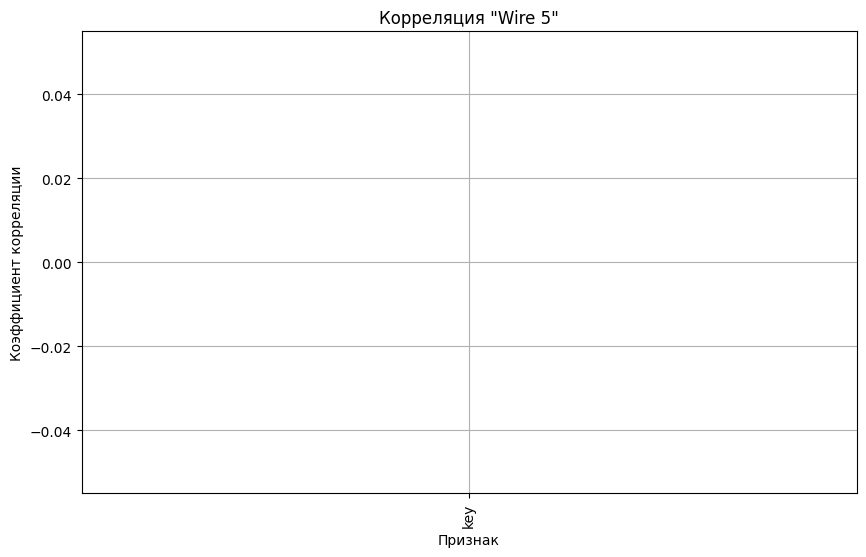

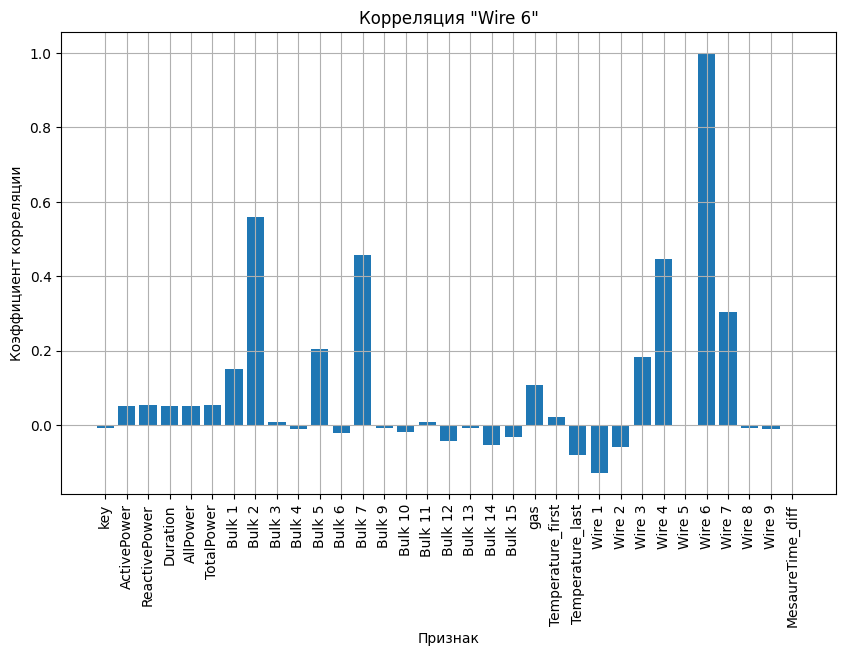

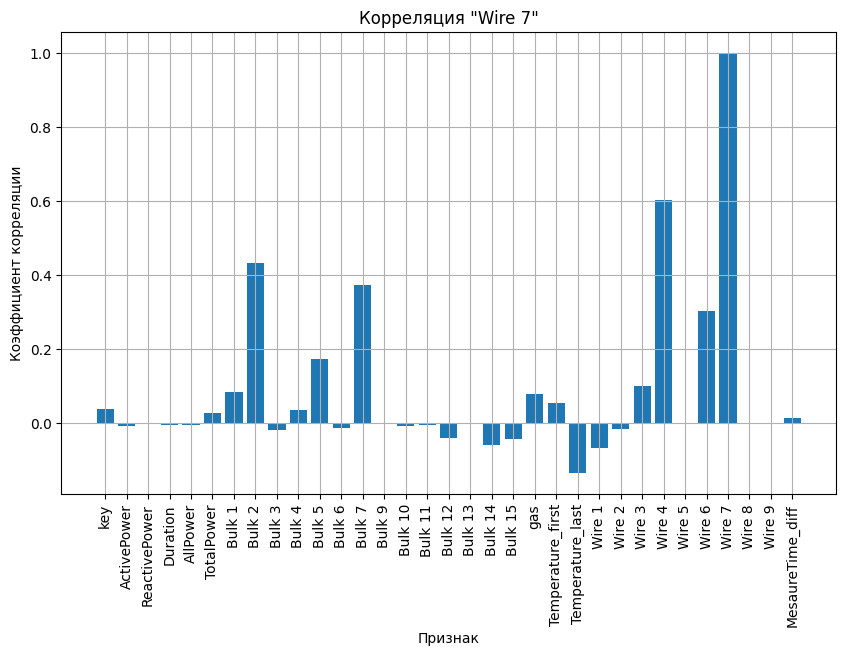

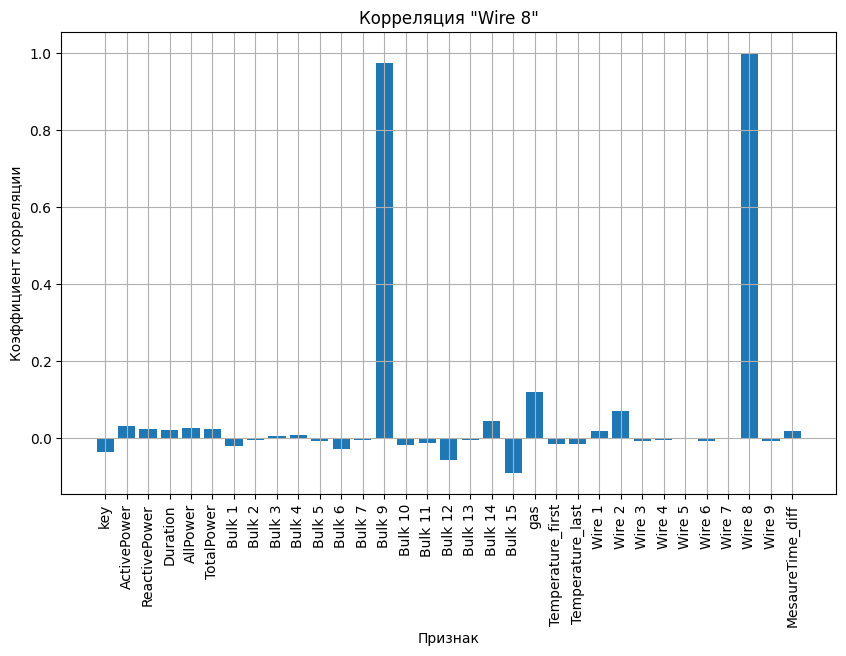

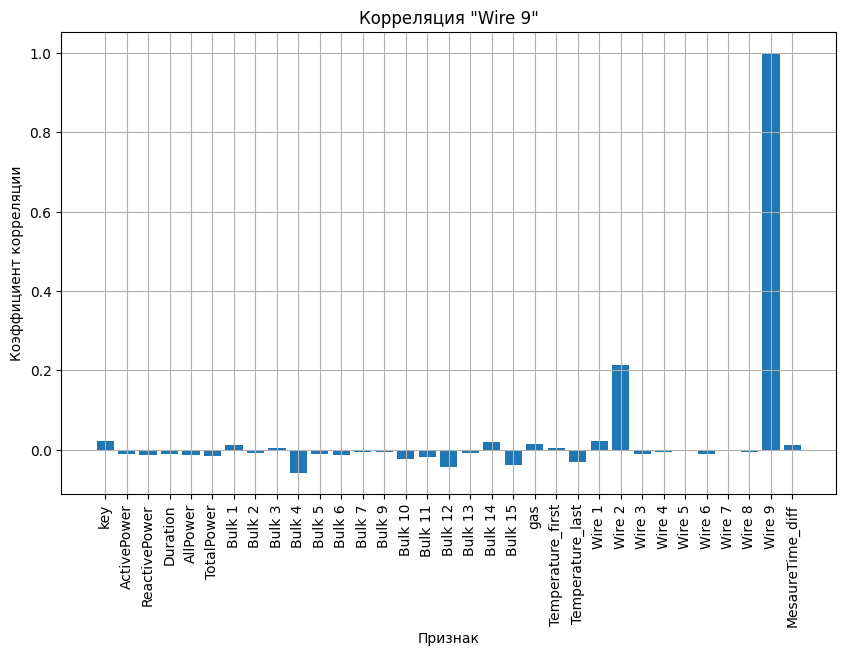

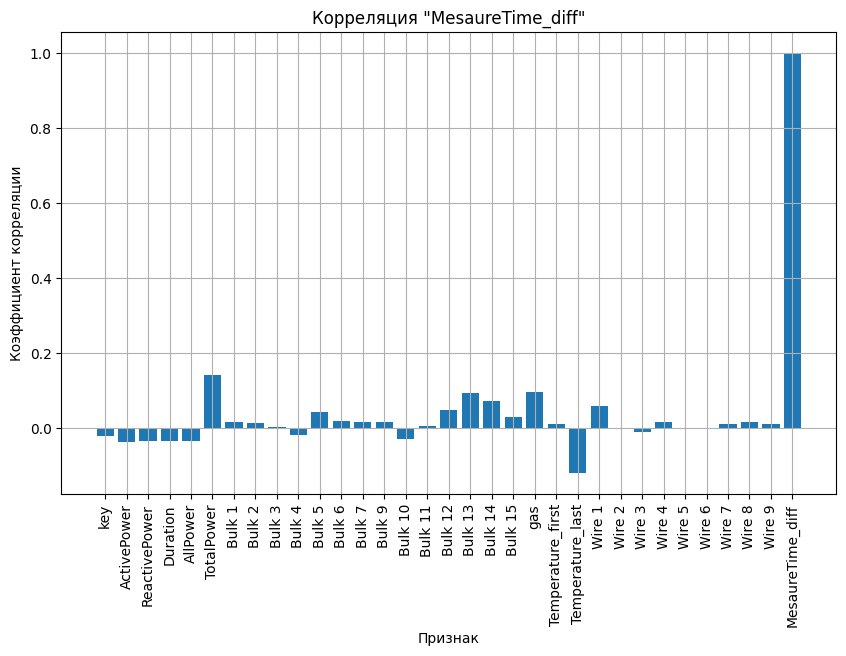

In [ ]:
plot_feature_correlations(df)

- Если смотреть на графики корреляции, то видно, что сильнее всего с целевым признаком коррелирует начальная температура, Bulk 4, Bulk 6, Bulk 11, Bulk 12, Bulk 15 и другой тип материалов Wire 1, 2, 4
- Есть слабая корреляция с реактивной мощностью
- Слабая корреляция с газом
- Еще более слабая корреляция с временными диапазонами и другими признаками
- Можно попробовать удалить столбцы с корреляцией
- Большое количество нулей в принципе плохо скажется на модели, т.к. они увеличивают общую дисперсию и могут приводить к смещению коэффициентов регрессии.


In [ ]:
corr_matrix = df.corr()

In [ ]:
def drop_highly_correlated_features(df, corr_matrix, threshold=0.9):

    to_drop = []

    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            feature1 = corr_matrix.columns[i]
            feature2 = corr_matrix.columns[j]
            corr = abs(corr_matrix.iloc[i, j])

            if corr >= threshold:
                to_drop.append(feature2)

    to_drop = list(set(to_drop))

    df_sorted = df.drop(to_drop, axis=1)
    print(f"Удалены следующие признаки: {', '.join(to_drop)}")

    return df_sorted

In [ ]:
drop_highly_correlated_features(df, corr_matrix, threshold=0.9)

Удалены следующие признаки: ActivePower, Bulk 9, ReactivePower, Duration


,key,AllPower,TotalPower,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,MesaureTime_diff
0,1,1.663142,8.061388,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,861.0
5,2,0.721107,5.050710,0.0,0.0,0.0,73.0,0.0,0.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1305.0
9,3,1.733547,4.124958,0.0,0.0,0.0,34.0,0.0,0.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1300.0
14,4,1.489718,5.269548,0.0,0.0,0.0,81.0,0.0,0.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,388.0
18,5,1.640548,5.599815,0.0,0.0,0.0,78.0,0.0,0.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,762.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10731,2495,1.580302,5.571467,0.0,0.0,21.0,0.0,0.0,0.0,0.0,...,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1137.0
10735,2496,0.680981,7.013249,0.0,0.0,0.0,63.0,0.0,0.0,0.0,...,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1618.0
10741,2497,1.085495,4.063648,0.0,0.0,0.0,85.0,0.0,0.0,0.0,...,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,717.0
10744,2498,1.995413,5.764154,0.0,0.0,90.0,0.0,0.0,0.0,0.0,...,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1302.0


## Промежуточный вывод
- Объединили таблицы по ключу
- Таблицы с временем загрузки материала не присоединяли, т.к. данные неинформативны
- Столбцы с датами и временем нагрева (BeginHeat и EndHeat) использовать не будем, т.к. уже получен столбце с продолжительностью нагрева, а сами по себе значения старта и конца нагрева ничего не дадут
- Далее проведен исследовательский анализ полученного датасета
- Найдены аномальные значения в столбце с длительностью нагрева и устранены
- В среднем длительность нагрева в диапазоне от 100 - 150 секунд
- Bulk 1 использовался редко, менее 300 раз
- Самое большое значение 185
- Bulk 2 использовался еще меньше, но и значения объема тут значительнее, все больше 220
- Почти в половине случаев использовали Bulk 3
- Чаще всего использовали в малых объемах от 20 до 150
- Bulk 4 использовали только в трети случаев
- Bulk 5 можно сказать почти не использовали, лишь в менее 100 случаев
- Bulk 6 тоже использовался редко, меньше чем в трети случае
- Чуть больше 20 случаев использования Bulk 7
- Далее до Bulk 12 материалы использовались редко или почти не использовались
- Bulk 12 использовался чаще других материалов, при чем иногда в очень больших объемах
- Максимальный объем при использовании около 1800
- Минимальный объем около 50
- В среднем объем около 250
- Bulk 13 использовался лиш в некоторых случаях, менее 20 раз
- Bulk 14 как и Bulk 12 использовался чаще других материалов и даже больше чем Bulk 12
- Однако объемы меньше: максимальное около 650, минимальное окло 20
- В среднем объем составляет около 200
- Не использовался этот материал всего в 312 случаях из 3000
- Bulk 15 тоже использовался относительно часто, в более чем 2/3 случаев
- Максмиальный объем при использовании составляет 400
- Минимальный около 10
- В среднем объем около 150

Если суммировать результаты по анализу материала Bulk, то можно выделить следующие тезисы:
- Большинство материалов используется редко
- Чаще всего используется материал Bulk 12, 14, 15
- В среднем объем материала при использовании составляет около 200
- Далее проанализированы столбцы MesaureTime, сами по себе они ничего не дали, но помогли создать новый признак, а именно диапазон времени между замерами
- Добавил новый столбец MesaureTime_diff, в котором хранится промежуток между первым и последним замером температуры в секундах
- Столбцы MesaureTime_last и MesaureTime_first удалил
- Самое большое значение между замерами равно почти суткам
- Минимальное время между замерами равно 0
- И то и другое выглядит скорее как аномалия, но если сутки при большом объеме еще могут в теории быть, то 0 точно нет
- Аномалия 0 заменена на среднее время
- Большие значения возможно связаны с объемами
- Максимальное значение 86213 секунд (23.9 часов)
- Минимальное значение 197 секунд (около 3 минут)
- Среднее время между первым и последним замерами 1641 секунда (27 минут)
- Далее был столбец с первичной температурой
- Среднее значение 1587
- Минимальное 1519
- Максимальное 1660
- Затем столбец с целевой переменной
- Среднее чуть выше: 1591
- Минимальное 1529
- Максимальное 1653
- Глобально я бы не сказал, что температурные значения сильно сдвинулись, это говорит о том, что первичная температура в некоторых случаях совпадает с конечной
- Далее идет информация о материале Wire
- Wire 1 имеет явное среднее значение около 100
- Глобально материал использовался почти всегда
- Wire 2 использовался только в 1/3 случаев
- Среднее значение объема около 50
- Wire 3, 4 почти не использовали
- Wire 5 использовался только 1 раз
- Wire 6, 7, 8, 9 почти не использовался
- Далее был проведен корреляционный анализ
- Сильнее всего коррелирует начальная температура, Bulk 4, Bulk 6, Bulk 11, Bulk 12, Bulk 15 и другой тип материалов Wire 1, 2, 4
- Есть слабая корреляция с реактивной мощностью
- Слабая корреляция с газом
- Еще более слабая корреляция с временными диапазонами и другими признаками
- Удалили столбцы с плохой корреляцией.
- Большое количество нулей в принципе плохо скажется на модели, т.к. они увеличивают общую дисперсию и могут приводить к смещению коэффициентов регрессии.
- Получили итоговый датасет, который с 2288 строками и 29 столбцами

## 3. Обучение моделей

- Выделим отдельно признаки и целевую переменную

In [ ]:
features = df.drop('Temperature_last', axis=1)
target = df['Temperature_last']
print('Features shape:', features.shape)
print('Target shape:', target.shape)

Features shape: (2287, 32)
Target shape: (2287,)


- Разделим на выборки
- Для классических ML-моделей мы будем использовать кросс-валидацию с помощью GridSearch, поэтому там будет достаточно раздедления на тест и трейн
- Для нейросети нам нужно разделить трейн еще и на валидацию

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)

In [ ]:
print('features_train shape:', features_train.shape)
print('features_test shape:', features_test.shape)
print('target_train shape', target_train.shape)
print('target_test shape', target_test.shape)

features_train shape: (1715, 32)
features_test shape: (572, 32)
target_train shape (1715,)
target_test shape (572,)


In [ ]:
features_train_nn, features_val, target_train_nn, target_val = train_test_split(features_train, target_train, test_size=0.2, random_state=RANDOM_STATE)

- В качетсве baseline возьмем константную модель, бедем сравнивать с ней все последующие для проверки на адекватность

In [ ]:
dummy = DummyRegressor()
dummy.fit(features_train_nn, target_train_nn)

DummyRegressor()

In [ ]:
dummy_preds = dummy.predict(features_val)

In [ ]:
dummy_score = mean_absolute_error(target_val, dummy_preds)
print("Dummy model MAE:", dummy_score)

Dummy model MAE: 8.444901784120573


- Итак, метрика константной модели 10.8
- Таргет для моделей, которые будем обучать < 6.8
- Начем с обучения деревянной модели
- Соберем названия столбцов в переменную, чтобы потом передать в трансформер

In [ ]:
columns_names = features.columns.tolist()
columns_names

['key',
 'ActivePower',
 'ReactivePower',
 'Duration',
 'AllPower',
 'TotalPower',
 'Bulk 1',
 'Bulk 2',
 'Bulk 3',
 'Bulk 4',
 'Bulk 5',
 'Bulk 6',
 'Bulk 7',
 'Bulk 9',
 'Bulk 10',
 'Bulk 11',
 'Bulk 12',
 'Bulk 13',
 'Bulk 14',
 'Bulk 15',
 'gas',
 'Temperature_first',
 'Wire 1',
 'Wire 2',
 'Wire 3',
 'Wire 4',
 'Wire 5',
 'Wire 6',
 'Wire 7',
 'Wire 8',
 'Wire 9',
 'MesaureTime_diff']

- Создаем препроцессор с помощью ColumnTransformer

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), columns_names)
    ]
)

- Создаем Pipeline

In [ ]:
pipeline_rndm = Pipeline([
    ('preprocessor', preprocessor),
    ('forest',RandomForestRegressor(random_state=RANDOM_STATE))
])

- Обозначаем гиперпараметры для подбора

In [ ]:
parameters_rndm = {
    'forest__n_estimators': [50, 75, 100],
    'forest__max_depth': [2, 5, 7]
}

- Создаем объект GridSearchCV для кросс-валидации

In [ ]:
gridsearch_rndm = GridSearchCV(pipeline_rndm, parameters_rndm, cv=5, scoring='neg_mean_absolute_error')

In [ ]:
gridsearch_rndm.fit(features_train, target_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         RobustScaler(),
                                                                         ['key',
                                                                          'ActivePower',
                                                                          'ReactivePower',
                                                                          'Duration',
                                                                          'AllPower',
                                                                          'TotalPower',
                                                                          'Bulk '
                                                                          '1',
                                                                          'Bulk '
                                                                          '2',
                                                                          'Bulk '
                                                                          '3',
                                                                          'Bulk '
                                                                          '4',
                                                                          'Bulk '
                                                                          '5',
                                                                          'Bulk '
                                                                          '6',
                                                                          'Bulk '
                                                                          '7',
                                                                          'Bulk '
                                                                          '9',
                                                                          'Bulk '
                                                                          '10',
                                                                          'Bulk '
                                                                          '11',
                                                                          'Bulk '
                                                                          '12',
                                                                          'Bulk '
                                                                          '13',
                                                                          'Bulk '
                                                                          '14',
                                                                          'Bulk '
                                                                          '15',
                                                                          'gas',
                                                                          'Temperature_first',
                                                                          'Wire '
                                                                          '1',
                                                                          'Wire '
                                                                          '2',
                                                                          'Wire '
                                                                          '3',
                                                                          'Wire '
                                                                          '4',
                                                                          'Wire '
                                                                         

In [ ]:
print('Метрика MAE модели случайного леса:', - gridsearch_rndm.best_score_)

Метрика MAE модели случайного леса: 6.276598753732347


- Метрика лучше чем у константной модели и уже выше таргета: 5.6
- Перейдем к следующей модели - градиентному бустингу
- Т.к. Cabtboost умеет самостоятельно масштабировать признаки, то в Пайплайн не будем передавать трансформер - модель сделает все сама,
- Можно обойтись и без пайплайна, однако для расширения возможности тестирования, я бы все таки использовал его, например, если захотим проверить как обучится модель с внешним масштабированием

In [ ]:
pipeline_cbst = Pipeline([
    ('boost', CatBoostRegressor(random_state=RANDOM_STATE))
])

In [ ]:
parameters_cbst = {
    'boost__n_estimators': [50, 75, 100],
    'boost__max_depth': [2, 5, 7]
}

In [ ]:
gridsearch_cbst = GridSearchCV(pipeline_cbst, parameters_cbst, cv=5, scoring='neg_mean_absolute_error')

In [ ]:
gridsearch_cbst.fit(features_train, target_train, boost__verbose=0)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('boost',
                                        <catboost.core.CatBoostRegressor object at 0x7f0f92b42e60>)]),
             param_grid={'boost__max_depth': [2, 5, 7],
                         'boost__n_estimators': [50, 75, 100]},
             scoring='neg_mean_absolute_error')

In [ ]:
print('Метрика MAE градиентного бустинга:', -gridsearch_cbst.best_score_)

Метрика MAE градиентного бустинга: 5.886591676333693


- Метрика градиентного бустинга хуже, чем случайного леса, но уже выше таргета: 6.3
- Попробуем еще одну модель бустинга - LGBMRegressor

In [ ]:
pipeline_lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('lgbm', LGBMRegressor(random_state=RANDOM_STATE, verbose=-1))
])

In [ ]:
parameters_lgbm = {
    'lgbm__n_estimators': [50, 75, 100],
    'lgbm__max_depth': [2, 5, 7]
}

In [ ]:
gridsearch_lgbm = GridSearchCV(pipeline_lgbm, parameters_lgbm, cv=5, scoring='neg_mean_absolute_error')

In [ ]:
gridsearch_lgbm.fit(features_train, target_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         RobustScaler(),
                                                                         ['key',
                                                                          'ActivePower',
                                                                          'ReactivePower',
                                                                          'Duration',
                                                                          'AllPower',
                                                                          'TotalPower',
                                                                          'Bulk '
                                                                          '1',
                                                                          'Bulk '
                                                                          '2',
                                                                          'Bulk '
                                                                          '3',
                                                                          'Bulk '
                                                                          '4',
                                                                          'Bulk '
                                                                          '5',
                                                                          'Bulk '
                                                                          '6',
                                                                          'Bulk '
                                                                          '7',
                                                                          'Bulk '
                                                                          '9',
                                                                          'Bulk '
                                                                          '10',
                                                                          'Bulk '
                                                                          '11',
                                                                          'Bulk '
                                                                          '12',
                                                                          'Bulk '
                                                                          '13',
                                                                          'Bulk '
                                                                          '14',
                                                                          'Bulk '
                                                                          '15',
                                                                          'gas',
                                                                          'Temperature_first',
                                                                          'Wire '
                                                                          '1',
                                                                          'Wire '
                                                                          '2',
                                                                          'Wire '
                                                                          '3',
                                                                          'Wire '
                                                                          '4',
                                                                          'Wire '
                                                                         

In [ ]:
print('Метрика MAE модели LGBM:', -gridsearch_lgbm.best_score_)

Метрика MAE модели LGBM: 5.859924521509938


- Попробуем для сравнения нейронную сеть
- Создадим касс нашей нейросети

In [ ]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1,
                 n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons):

        super(Net, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.2)

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.drop2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(n_hidden_neurons_3, n_out_neurons)
        self.act4 = nn.ReLU()

        nn.init.uniform_(self.fc1.weight, a=-7, b=4)
        nn.init.uniform_(self.fc1.bias, a=-3, b=1)
        nn.init.kaiming_uniform_(self.fc2.weight)
        nn.init.normal_(self.fc2.bias, mean=2, std=0.3536)
        nn.init.kaiming_uniform_(self.fc3.weight)
        nn.init.normal_(self.fc3.bias, mean=2, std=0.3536)
        nn.init.kaiming_uniform_(self.fc4.weight)
        nn.init.normal_(self.fc4.bias, mean=2, std=0.3536)


    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.drop1(x)

        x = self.fc2(x)
        x = self.act2(x)
        x = self.drop2(x)

        x = self.fc3(x)
        x = self.act3(x)
        x = self.drop3(x)

        x = self.fc4(x)
        x = self.act4(x)


        return x

- Далее переведем признаки в тензоры
- Но сначала сделаем масштабирование и преобразуем их в numpy array

In [ ]:
features_train_nn_pr = preprocessor.fit_transform(features_train_nn)

features_val_pr = preprocessor.transform(features_val)

features_test_pr = preprocessor.transform(features_test)

In [ ]:
X_train_nn = np.array(features_train_nn_pr)
y_train_nn = np.array(target_train_nn)

X_val = np.array(features_val_pr)
y_val = np.array(target_val)

X_test = np.array(features_test_pr)
y_test = np.array(target_test)

In [ ]:
X_train_tensor = torch.FloatTensor(X_train_nn)
y_train_tensor = torch.FloatTensor(y_train_nn).unsqueeze(1)

X_valid_tensor = torch.FloatTensor(X_val)
y_valid_tensor = torch.FloatTensor(y_val).unsqueeze(1)

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

- Далее задаем параметры нашей нейросети

In [ ]:
n_in_neurons = X_train_tensor.shape[1]
n_out_neurons = 1
n_hidden_neurons_1 = 512
n_hidden_neurons_2 = 256
n_hidden_neurons_3 = 64

In [ ]:
criterion = nn.L1Loss()

In [ ]:
model_nnn = Net(n_in_neurons, n_hidden_neurons_1,
            n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons)

In [ ]:
optimizer = torch.optim.Adam(model_nnn.parameters(), lr=0.0001)

In [ ]:
num_epochs = 2000
for epoch in range(num_epochs):

    model_nnn.train()
    optimizer.zero_grad()

    outputs = model_nnn(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        model_nnn.eval()
        train_preds = model_nnn.forward(X_train_tensor)
        test_preds = model_nnn.forward(X_valid_tensor)
        mae = criterion(test_preds, y_valid_tensor)
        print(mae)

tensor(1470.0035, grad_fn=<MeanBackward0>)
tensor(1107.8483, grad_fn=<MeanBackward0>)
tensor(1033.0337, grad_fn=<MeanBackward0>)
tensor(918.0150, grad_fn=<MeanBackward0>)
tensor(798.0565, grad_fn=<MeanBackward0>)
tensor(694.0405, grad_fn=<MeanBackward0>)
tensor(637.5213, grad_fn=<MeanBackward0>)
tensor(609.4575, grad_fn=<MeanBackward0>)
tensor(569.8087, grad_fn=<MeanBackward0>)
tensor(546.5179, grad_fn=<MeanBackward0>)
tensor(517.2627, grad_fn=<MeanBackward0>)
tensor(504.1149, grad_fn=<MeanBackward0>)
tensor(473.2251, grad_fn=<MeanBackward0>)
tensor(464.8637, grad_fn=<MeanBackward0>)
tensor(448.1807, grad_fn=<MeanBackward0>)
tensor(443.5426, grad_fn=<MeanBackward0>)
tensor(431.7806, grad_fn=<MeanBackward0>)
tensor(425.6662, grad_fn=<MeanBackward0>)
tensor(418.7924, grad_fn=<MeanBackward0>)
tensor(416.3702, grad_fn=<MeanBackward0>)


In [ ]:
model_nnn.train()

Net(
  (fc1): Linear(in_features=32, out_features=512, bias=True)
  (act1): ReLU()
  (drop1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (act2): ReLU()
  (drop2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (act3): ReLU()
  (drop3): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (act4): ReLU()
)

In [ ]:
model_nnn.eval()

Net(
  (fc1): Linear(in_features=32, out_features=512, bias=True)
  (act1): ReLU()
  (drop1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (act2): ReLU()
  (drop2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (act3): ReLU()
  (drop3): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (act4): ReLU()
)

In [ ]:
nn_preds = model_nnn.forward(X_valid_tensor)
score = criterion(nn_preds, y_valid_tensor)
print("MAE нейросети:", score)

MAE нейросети: tensor(415.2811, grad_fn=<MeanBackward0>)


- Метрика нейронной сети намного хуже чем у деревянной модели и градиентного бустинга, даже при обучении на большом количестве эпох и при использовании разных параметров (lr, количество нейронов и т.д.)
- Построим сводную таблицу с метриками для наглядности

In [ ]:
best_forest = -gridsearch_rndm.best_score_
best_boost = -gridsearch_cbst.best_score_
best_gbm = -gridsearch_lgbm.best_score_

In [ ]:
index = ['Случайный лес', 'CatBoost', 'LGBM', 'Нейронная сеть', 'Константная модель']
columns = ['MAE']

summary = pd.DataFrame({
    'MAE':[best_forest, best_boost, best_gbm, score.item(), dummy_score]}, index=index)
display(summary)

,MAE
Случайный лес,6.276599
CatBoost,5.886592
LGBM,5.859925
Нейронная сеть,415.281067
Константная модель,8.444902


- Если смотреть на таблицу выше, то лучше всего себя показывает градиентный бустинг LGBMRegressor
- Модель адекватная, так как метрика выше константной модели и соответствует таргету
- Возьмем эту модель в качестве лучшей и протестируем на тестовой выборке

## 4. Тестирование лучшей модели

In [ ]:
best_model = gridsearch_lgbm.best_estimator_

In [ ]:
best_preds = best_model.predict(features_test)

In [ ]:
best_score = mean_absolute_error(target_test, best_preds)

In [ ]:
print('Качество лучшей модели на тесте:', best_score)

Качество лучшей модели на тесте: 5.8871320191383285


In [ ]:
r2 = r2_score(target_test, best_preds)

In [ ]:
print('Метрика R2 лучшей модели:', r2)

Метрика R2 лучшей модели: 0.4707054316162116


- На тесте модель показывает хорошее качество выше таргета: 5.8
- Если смотерть на метрику R2, то можно сказать, что модель объясняет некоторую долю вариации в целевой переменной, а именно 0.47, что неплохой, но не самый лучший результат
- Сравним с константной моделью

In [ ]:
dummy_test_preds = dummy.predict(features_test)

In [ ]:
dummy_test_score = mean_absolute_error(target_test, dummy_test_preds)

In [ ]:
print('Качество константной модели на тесте:', dummy_test_score)

Качество константной модели на тесте: 8.136144467777129


In [ ]:
dummy_r2 = r2_score(target_test, dummy_test_preds)
print('Метрика R2 константной модели:', dummy_r2)

Метрика R2 константной модели: -0.001399022969555297


- Если сравнивать эту модель с константной, то налицо видна была разница: метрика MAE лучше модели 5.8, а константной 8.1, что говорит о вменяемости обученной модели
- Метрика R2 константной модели так же доказывает вышесказанное: у константной модели отрицательный результат, что говорит о том, что dummy предсказывает хуже чем просто использование среднего значения
- Перейдем к анализу важности признаков

In [ ]:
rf = best_model.named_steps['lgbm']

In [ ]:
importances = rf.feature_importances_

In [ ]:
indices = np.argsort(importances)[::-1]

In [ ]:
features_names = preprocessor.get_feature_names_out()

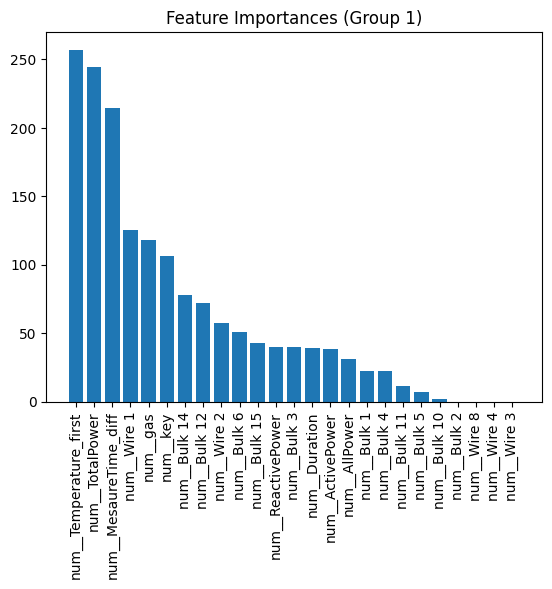

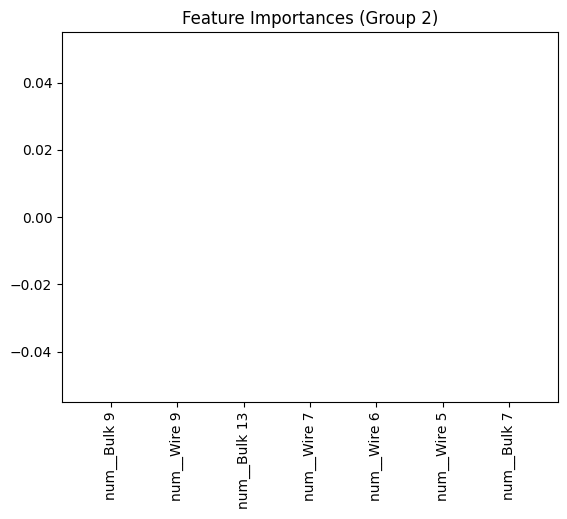

In [ ]:
group_size = 25
num_groups = int(np.ceil(len(importances) / group_size))


for i in range(num_groups):
    start = i * group_size
    end = (i + 1) * group_size

    plt.figure()
    plt.title("Feature Importances (Group {})".format(i+1))
    plt.bar(range(len(importances[start:end])), importances[indices[start:end]], align="center")
    plt.xticks(range(len(importances[start:end])), features_names[indices[start:end]], rotation='vertical')
    plt.show()

- Самыми важными являются признаки первичной температуры, общей мощности, времени между замерами, данные по газу и некоторым материалам, а также номер партии
- Построим график зависимости признака первичной температуры и целевого признака

In [ ]:
X = df['Temperature_first']
y = df['Temperature_last']

data = pd.DataFrame({'Feature': X, 'Target': y})

pivot_table = data.pivot_table(index='Feature', values='Target', aggfunc='mean')
pivot_table

,Target
Feature,
1519.0,1580.00
1520.0,1585.50
1525.0,1580.00
1526.0,1573.50
1527.0,1576.00
...,...
1651.0,1608.50
1652.0,1599.25
1654.0,1606.50


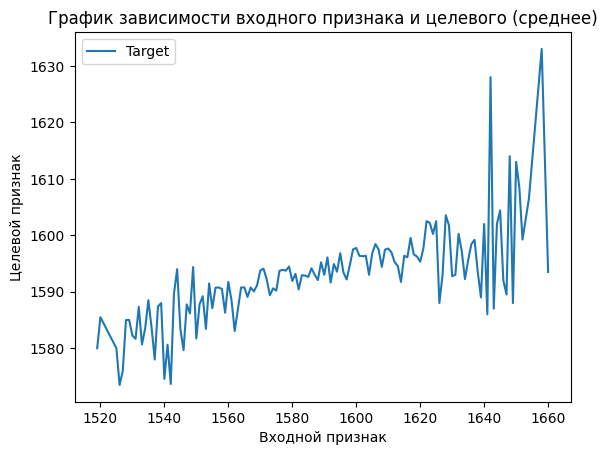

In [ ]:
pivot_table.plot(kind='line')
plt.xlabel('Входной признак')
plt.ylabel('Целевой признак')
plt.title('График зависимости входного признака и целевого (среднее)')
plt.show()

- В общем то график показывает информацию, которая была выше: на лицо зависимости целевой переменной от этого признака

## 5. Общий вывод
- Данные были загружены из БД PostgreSQL
- Проведен EDA и предобработка данных во всех таблицах
- В некоторых таблицых были найдены и устранены аномалии
- Некоторые таблицы, такие как таблица со временем загрузки материала были неинформативными и не использовались в дальнейшей работе
- Были сгенирированы новые признаки, например, длительность прогрева электродов и временной диапазон между температурными замерами
- Таблицы были объединены в один датасет по ключу (номер партии)
- Для финального датасета также проведен EDA и предобработка данных (устранение аномалий)
- Затем датасет был разделен на 3 выборки для дальнейшего обучения моделей
- Также отдельно был выделен целевой признак
- Для тестирования выбраны несколько моделей
- В качестве baseline выбрана модель DummyRegressor - константная модель
- Использовались модели: Случайный лес, Градиентные бустинги (Catboost, LGBM), Нейронная сеть
- Для моделей Случайного леса и Градиентных бустингов использовался автоматический подбор гиперпараметров через GridSearchCV
- Для нейронной сети параметры подбирались вручную в несколько итераций
- В качестве метрики оценки качества использовалась MAE, далее приведены показатели моделей на валидации
- Случайный лес	6.27
- CatBoost	5.88
- LGBM	5.85
- Нейронная сеть	440
- Константная модель	8.1
- Лучше всего себя показала модель случайного леса, хуже всего нейросеть, несмотря на использование разных параметров и большого количества эпох обучения
- В качестве лучшей модели для тестирования вырана модель Случайного Леса
- На тесте модель показывает хорошее качество выше таргета: 5.8
- Для сравнения константная модель показывает 8.1
- Метрика R2 лучшей модели 0.47, а константной -0.001
- Также проведен анализ важности признаков
- Самым важным являются признаки связанные с первым замером температуры и номером партии
- Далее был построен график зависимости первичной температуры и целевого признака, который наглядно показывает зависимость

- Если говорить глобально о том, как можно улучшить качество модели, я бы советовал собрать больше данных, т.к. обучающая выборка получилась достаточно маленькой, а для той же нейросети это достаточно критично. Модель справляется неплохо, но бОльшее количество данных помогло бы улучшить метрику.
- Также можно пробовать убирать слабокоррелирующие признаки, чтобы сокращать дисперсию. Можно пройти в несколько итераций с разным количеством признаков, замеряя качество на каждой из итераций, постепенно улучшая качество модели.